In [1]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import datasets
from tqdm import tqdm
from datasets import Image as Image_ds # change name because of similar PIL module
from datasets import Dataset
from datasets import load_dataset
import urllib.parse
import json
import pickle
import requests
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors
import re
import sys
sys.path.append(os.path.abspath(".."))
from src.utils import plot_neighbors, pca_binary, plot_pca_scale, plot_dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
from random import sample
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib.patches import Patch
from sklearn.metrics.pairwise import cosine_distances
import seaborn as sns
from scipy.stats import spearmanr

#sys.path.append(os.path.abspath(".."))
from src.utils import WindowedRollingDistance
from src.utils import calc_vector_histogram
from scipy.ndimage import gaussian_filter1d

# we get a lot of annoying warnings from sklearn so we suppress them
import warnings
warnings.filterwarnings('ignore')

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/canon-paintings-smk/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

We load the SMK data + metadata in a couple of different formats:

df = Pandas DataFrame with SMK metadata on paintings

ds = HuggingFace dataset with same columns as pandas DF, but also a column storing a PIL image of the painting (mainly used here as it's easy to check the painting when it's stored in a ds)

In [2]:
# read df from pickle 
data_path = os.path.join('..', 'data')
df = pd.read_pickle(os.path.join(data_path, 'paintings_canonized.pkl'))

In [4]:
# load image data
ds = load_dataset("louisebrix/smk_only_paintings", split="train") # all the data is in the 'train' split

In [5]:
# change canon variables from 0 / 1 to other / canon
columns = ['exb_canon', 'dist_canon', 'on_display', 'smk_exhibitions']

for column in columns:
    df[column] = df[column].replace({0: 'other', 1: 'canon'})

### Sanity check image embeddings

Image embeddings are obtained by running the scripts 'src/smk_embeddings.py' and 'src/greyscale_embeddings.py'. The pretrained model used is EVA-02-CLIP, a multimodal vision transformer architecture. The embeddings are saved as .npy files in the /data folder but are loaded here as a column in the dataframe. There's two types of embeddings:
- 'as they are' i.e., embeddings extracted from the downloaded image from SMK
- greyscaled embeddings: SMK are first converted to greyscale, then embeddings are extracted from the greyscaled images.

As a type of sanity check, we make sure that our embeddings actually capture image content and style by running a kNN algorithm to find the nearest neighbors based on embeddings:

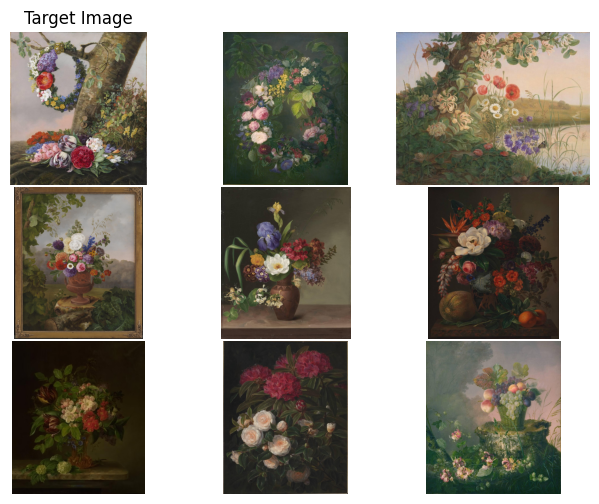

In [6]:
feature_list = np.array(df['embedding'].tolist())
plot_neighbors(feature_list, 80, ds) # choose random image as target image

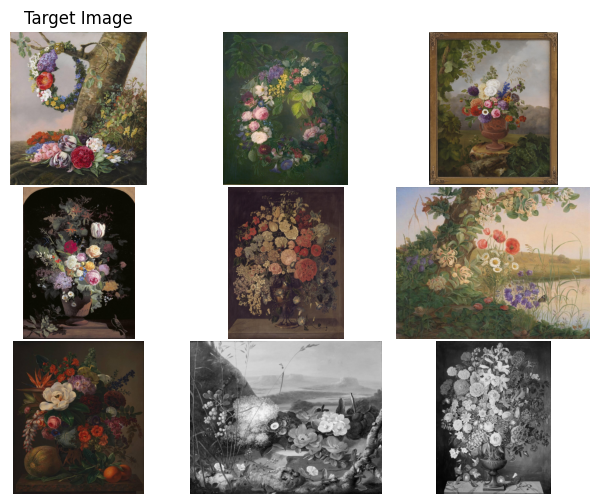

In [7]:
grey_feature_list = np.array(df['grey_embedding'].tolist())
plot_neighbors(grey_feature_list, 80, ds) # choose random image as target image

(Should be noted that I have not changed the actual PIL image to greyscale in the dataset, only done it before extracting the embedding, i.e., have not saved the greyscaled image. That is why the images are still colored)

### Create subset of colored images only

In [8]:
# make subset of colored images only 
color_subset = df.query('rgb == "color"')
color_idx = color_subset.index.tolist()
ds_color = ds.select(color_idx)

In [9]:
color_subset.reset_index(drop = True)

smk_id     period  start_year  \
0     KMS8884       1835        1835   
1     KMS4313       1870        1870   
2     KMS3880       1800        1800   
3     KMS7591       1800        1800   
4     KMS3769       1844        1844   
...       ...        ...         ...   
1094  KMS4154       1849        1849   
1095  KMS8817       1817        1817   
1096  KMS8925  1788-1792        1788   
1097  KMS9021  1825-1829        1825   
1098  KMS9034       1868        1868   

                                                title  \
0                            Parti af torvet i Amalfi   
1                        Leonora Christina i fængslet   
2                    Jurisprudensen. Allegorisk figur   
3                                          Filosofien   
4               Udsigt fra Athenatemplet på Akropolis   
...                                               ...   
1094             Landskab fra Skiveegnen med Skivehus   
1095                                    Efter stormen   
1096  Portræt af Kennett Dixon, der spiller badminton   
1097                                      Selvportræt   
1098    Portræt af maleren Thorald Læssøe (1816-1878)   

                    first_artist                   all_artists  num_artists  \
0                Martinus Rørbye             [Martinus Rørbye]            1   
1             Kristian Zahrtmann          [Kristian Zahrtmann]            1   
2             Nicolai Abildgaard          [Nicolai Abildgaard]            1   
3             Nicolai Abildgaard          [Nicolai Abildgaard]            1   
4                Martinus Rørbye             [Martinus Rørbye]            1   
...                          ...                           ...          ...   
1094          Christen Dalsgaard          [Christen Dalsgaard]            1   
1095      Caspar David Friedrich      [Caspar David Friedrich]            1   
1096             William Beechey             [William Beechey]            1   
1097       Emil Ditlev Bærentzen       [Emil Ditlev Bærentzen]            1   
1098  Elisabeth Jerichau Baumann  [Elisabeth Jerichau Baumann]            1   

     main_type all_types                                    image_thumbnail  \
0       Maleri  [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/tt44ps41w_km...   
1       Maleri  [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/7d278w98c_KM...   
2       Maleri  [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/mw22v869s_KM...   
3       Maleri  [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/3x816q91r_KM...   
4       Maleri  [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/w0892f396_KM...   
...        ...       ...                                                ...   
1094    Maleri  [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/6m311t23b_KM...   
1095    Maleri  [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/db78tg36b_KM...   
1096    Maleri  [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/rf55zc238_km...   
1097    Maleri  [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/9880vw79j_km...   
1098    Maleri  [Maleri]  https://iip-thumb.smk.dk/iiif/jp2/sb397d185_km...   

      ...  canon n_exhibitions n_golden_titles n_smk_exhibitions  \
0     ...  canon             3               3                 1   
1     ...  canon             6            <NA>                 0   
2     ...  canon             6               1                 1   
3     ...  canon             4            <NA>                 1   
4     ...  canon          <NA>            <NA>                 0   
...   ...    ...           ...             ...               ...   
1094  ...  canon             3            <NA>                 0   
1095  ...  canon             3            <NA>                 1   
1096  ...  canon          <NA>            <NA>                 0   
1097  ...  canon          <NA>            <NA>                 0   
1098  ...  canon          <NA>            <NA>                 0   

                                              embedding  \
0     [0.2547459602355957, -0.6865944862365723, 0.94...   
1     [0

## Test Paper 1 workflow

Creating PCA plot based on a preliminary combined binary canon definition (that I just defined for testing purposes). A painting is defined as canon if it has previously been part of an exhibition or is currently at display at SMK.

Text(0.5, 0.98, 'PCA with Combined Binary Canon Definition')

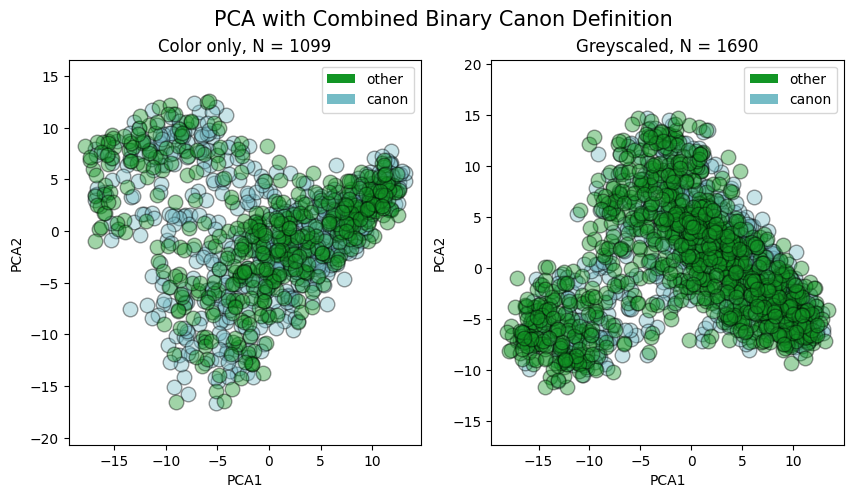

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

pca_binary(axs[0], color_subset, 'embedding', 'canon', f"Color only, N = {len(color_subset)}")
pca_binary(axs[1], df, 'grey_embedding', 'canon', f"Greyscaled, N = {len(df)}")
fig.suptitle('PCA with Combined Binary Canon Definition', size = 15)

Testing PCA plots with a continuous canon variable by coloring by number of exhibitions:

Text(0.5, 0.98, 'PCA colored by number of exhibitions')

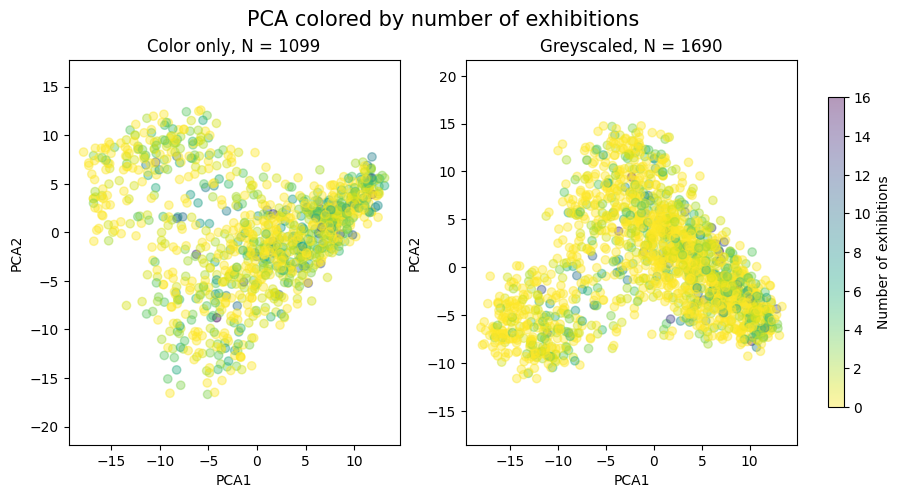

In [11]:
exb_df = df.fillna(0)
exb_color = color_subset.fillna(0)

# coloring by number of exhibitions
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sc1 = plot_pca_scale(axs[0], exb_color, 'embedding', "n_exhibitions", f"Color only, N = {len(color_subset)}", cmap='viridis_r')
sc2 = plot_pca_scale(axs[1], exb_df, 'grey_embedding', "n_exhibitions", f"Greyscaled, N = {len(df)}", cmap='viridis_r')

# add colorbar
cbar = fig.colorbar(sc1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label("Number of exhibitions")
fig.suptitle('PCA colored by number of exhibitions', size = 15)

### PCA plots per category

Text(0.5, 0.95, 'PCA with Binary Canon Definition by category')

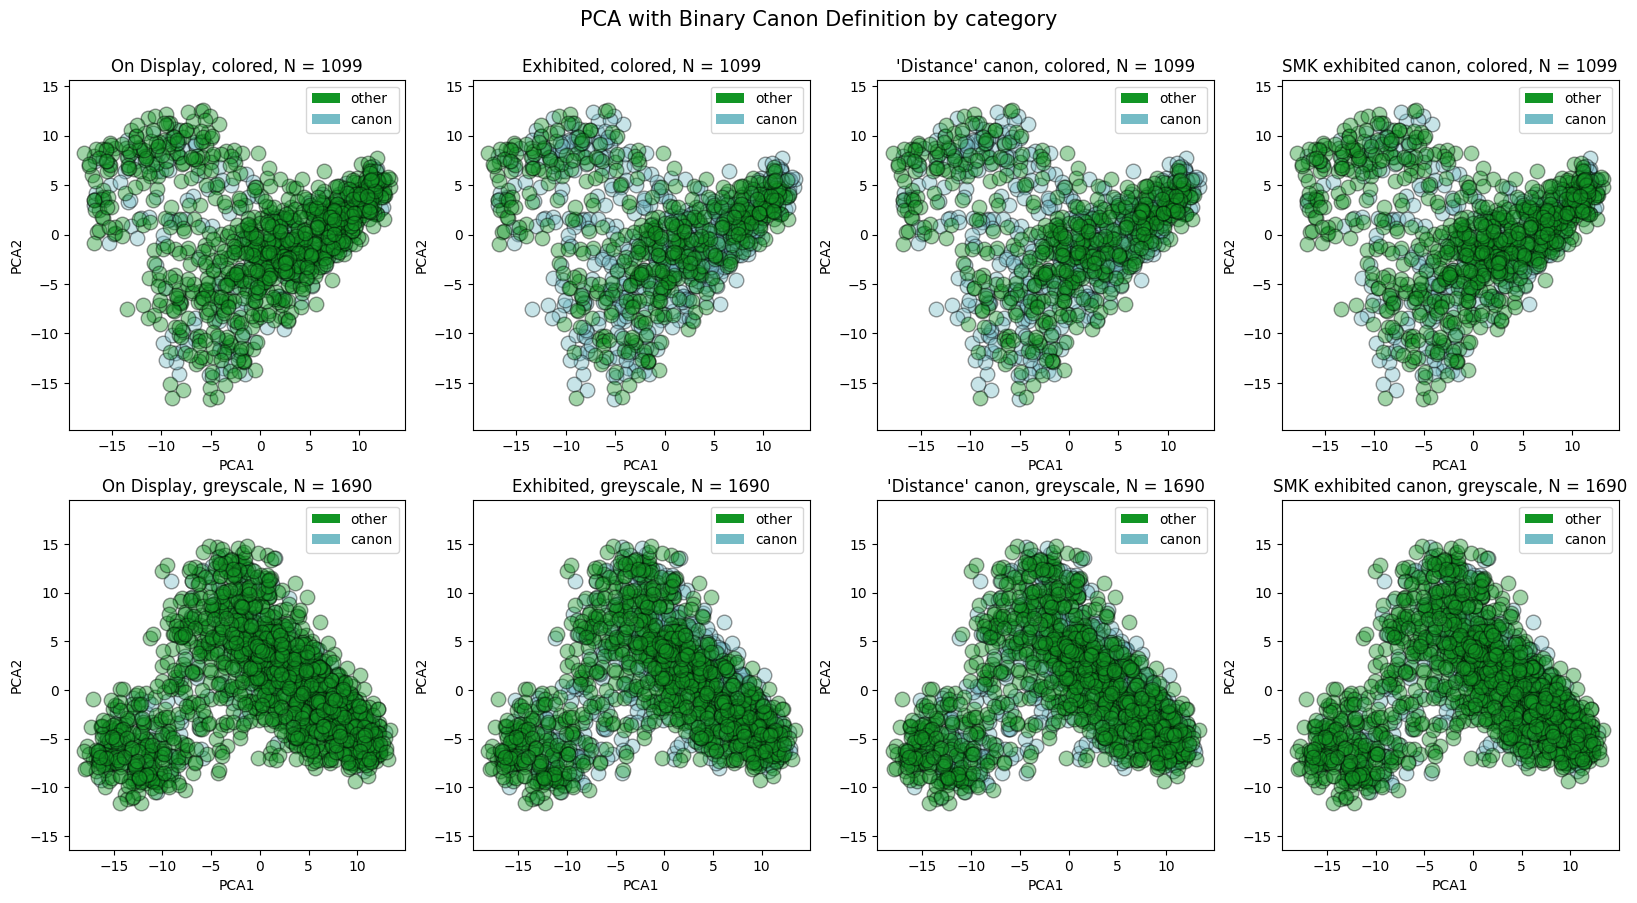

In [12]:
# PCA plots with binary canon variables
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

pca_binary(axs[0,0], color_subset, 'embedding', "on_display", f"On Display, colored, N = {len(color_subset)}")
pca_binary(axs[1,0], df, 'grey_embedding', "on_display", f"On Display, greyscale, N = {len(df)}")
pca_binary(axs[0,1], color_subset, 'embedding', "exb_canon", f"Exhibited, colored, N = {len(color_subset)}")
pca_binary(axs[1,1], df, 'grey_embedding', "exb_canon", f"Exhibited, greyscale, N = {len(df)}")
pca_binary(axs[0,2], color_subset, 'embedding', "dist_canon", f"'Distance' canon, colored, N = {len(color_subset)}")
pca_binary(axs[1,2], df, 'grey_embedding', "dist_canon", f"'Distance' canon, greyscale, N = {len(df)}")
pca_binary(axs[0,3], color_subset, 'embedding', "smk_exhibitions", f"SMK exhibited canon, colored, N = {len(color_subset)}")
pca_binary(axs[1,3], df, 'grey_embedding', "smk_exhibitions", f"SMK exhibited canon, greyscale, N = {len(df)}")
fig.suptitle('PCA with Binary Canon Definition by category', size = 15, y=0.95)

### Plot PCA embeddings for first and last part of the dataset

In [13]:
# dividing the dataset based on the median
df['start_year'].describe()

count    1690.000000
mean     1822.861538
std        30.666656
min      1750.000000
25%      1807.000000
50%      1831.500000
75%      1845.000000
max      1870.000000
Name: start_year, dtype: float64

In [14]:
first_half_grey = df.query("start_year < 1831")
second_half_grey = df.query("start_year >= 1831")
len(df) == len(first_half_grey) + len(second_half_grey)

True

In [15]:
# get median for color-subset
color_subset['start_year'].describe()

count    1099.000000
mean     1826.242948
std        28.882151
min      1750.000000
25%      1812.000000
50%      1834.000000
75%      1846.000000
max      1870.000000
Name: start_year, dtype: float64

In [16]:
first_half_color = color_subset.query("start_year < 1834")
second_half_color = color_subset.query("start_year >= 1834")

len(color_subset) == len(first_half_color) + len(second_half_color)

True

Text(0.5, 0.95, 'PCA with "distance" canon, first and second half of dataset')

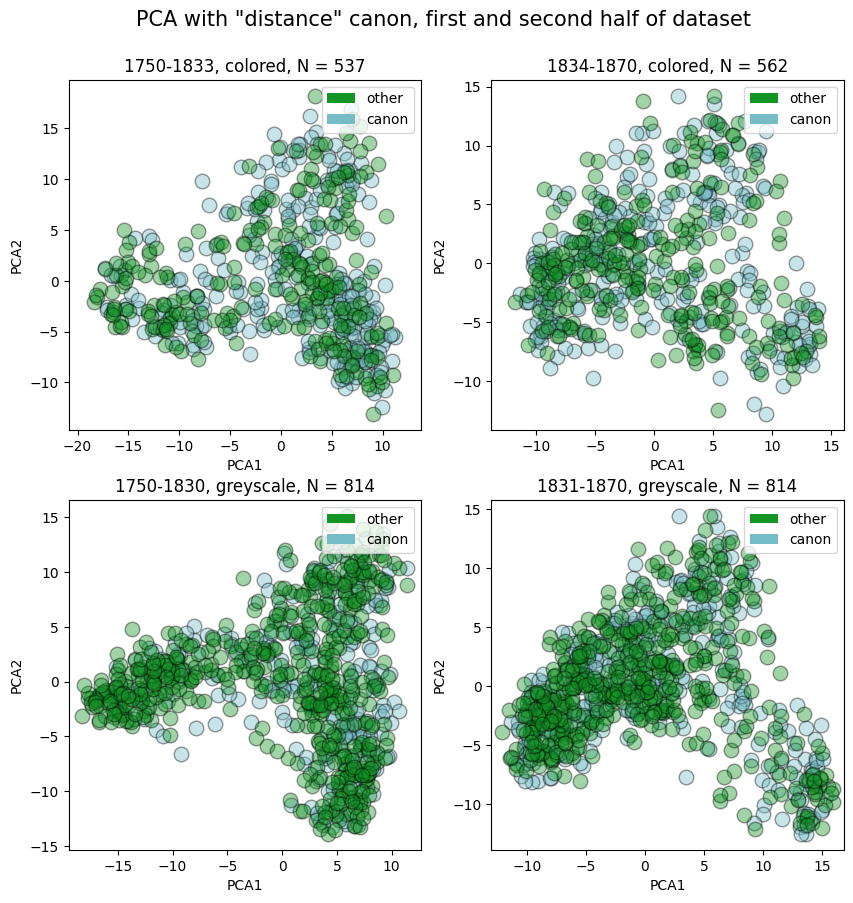

In [17]:
# Plot PCA per category

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

pca_binary(axs[0,0], first_half_color, 'embedding', "dist_canon", f"1750-1833, colored, N = {len(first_half_color)}")
pca_binary(axs[0,1], second_half_color, 'embedding', "dist_canon", f"1834-1870, colored, N = {len(second_half_color)}")
pca_binary(axs[1,0], first_half_grey, 'grey_embedding', "dist_canon", f"1750-1830, greyscale, N = {len(first_half_grey)}")
pca_binary(axs[1,1], second_half_grey, 'grey_embedding', "dist_canon", f"1831-1870, greyscale, N = {len(first_half_grey)}")

fig.suptitle('PCA with "distance" canon, first and second half of dataset', size = 15, y=0.95)

Text(0.5, 0.95, 'PCA with Exhibition canon, first and second half of dataset')

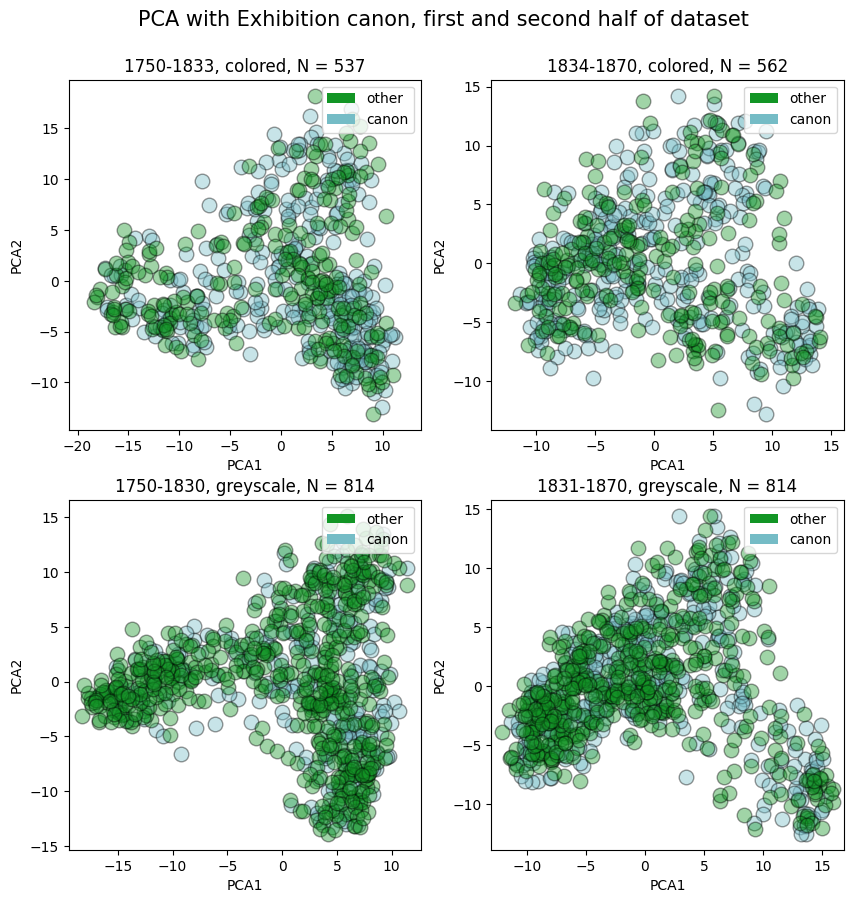

In [18]:
# Plot PCA per category

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

pca_binary(axs[0,0], first_half_color, 'embedding', "exb_canon", f"1750-1833, colored, N = {len(first_half_color)}")
pca_binary(axs[0,1], second_half_color, 'embedding', "exb_canon", f"1834-1870, colored, N = {len(second_half_color)}")
pca_binary(axs[1,0], first_half_grey, 'grey_embedding', "exb_canon", f"1750-1830, greyscale, N = {len(first_half_grey)}")
pca_binary(axs[1,1], second_half_grey, 'grey_embedding', "exb_canon", f"1831-1870, greyscale, N = {len(first_half_grey)}")

fig.suptitle('PCA with Exhibition canon, first and second half of dataset', size = 15, y=0.95)

Text(0.5, 0.95, 'PCA with SMK Exhibitions canon, first and second half of dataset')

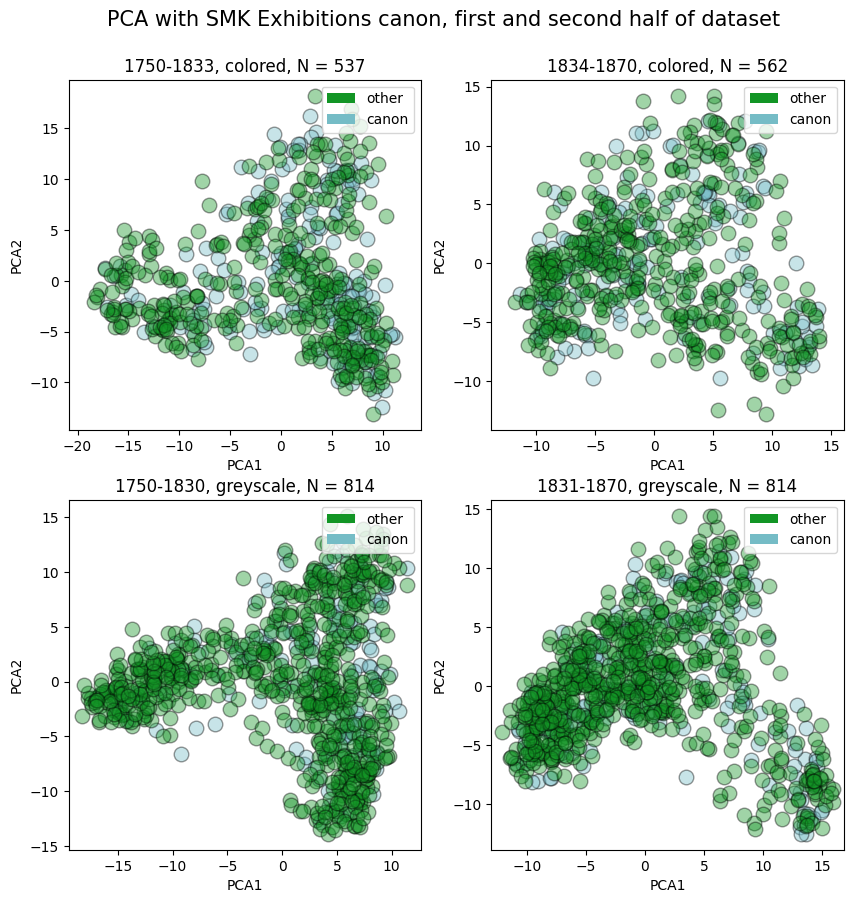

In [19]:
# Plot PCA per category

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

pca_binary(axs[0,0], first_half_color, 'embedding', "smk_exhibitions", f"1750-1833, colored, N = {len(first_half_color)}")
pca_binary(axs[0,1], second_half_color, 'embedding', "smk_exhibitions", f"1834-1870, colored, N = {len(second_half_color)}")
pca_binary(axs[1,0], first_half_grey, 'grey_embedding', "smk_exhibitions", f"1750-1830, greyscale, N = {len(first_half_grey)}")
pca_binary(axs[1,1], second_half_grey, 'grey_embedding', "smk_exhibitions", f"1831-1870, greyscale, N = {len(first_half_grey)}")

fig.suptitle('PCA with SMK Exhibitions canon, first and second half of dataset', size = 15, y=0.95)

Text(0.5, 0.95, 'PCA with On Display canon, first and second half of dataset')

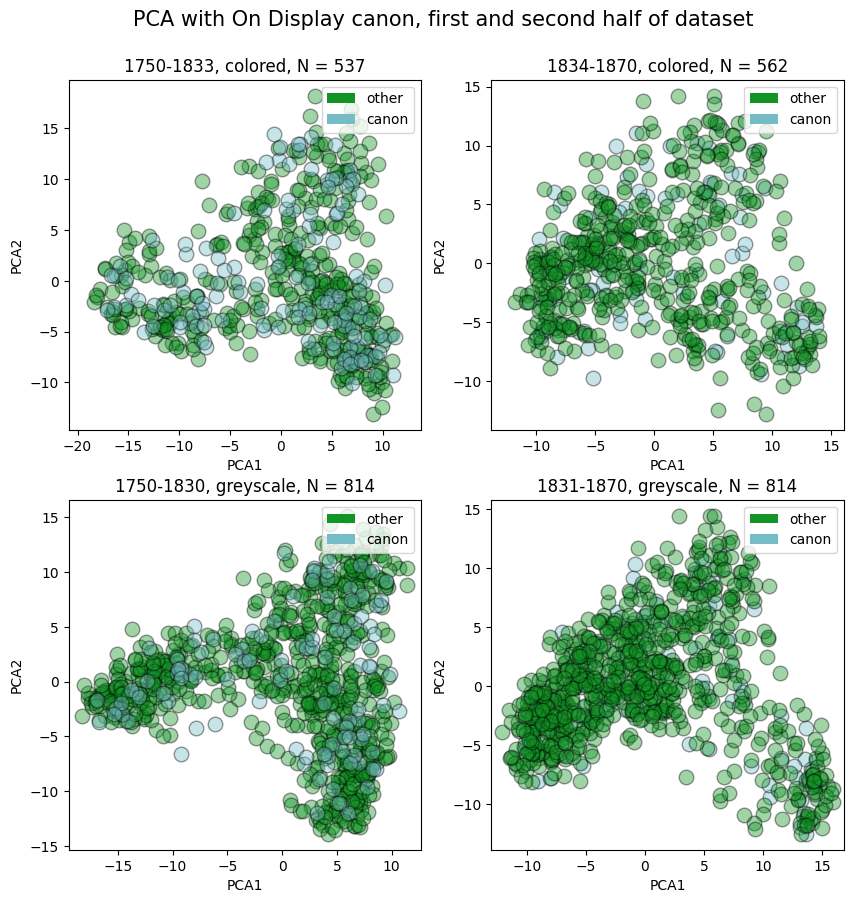

In [20]:
# Plot PCA per category

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

pca_binary(axs[0,0], first_half_color, 'embedding', "on_display", f"1750-1833, colored, N = {len(first_half_color)}")
pca_binary(axs[0,1], second_half_color, 'embedding', "on_display", f"1834-1870, colored, N = {len(second_half_color)}")
pca_binary(axs[1,0], first_half_grey, 'grey_embedding', "on_display", f"1750-1830, greyscale, N = {len(first_half_grey)}")
pca_binary(axs[1,1], second_half_grey, 'grey_embedding', "on_display", f"1831-1870, greyscale, N = {len(first_half_grey)}")

fig.suptitle('PCA with On Display canon, first and second half of dataset', size = 15, y=0.95)

In [21]:
first_half_color_nona = color_subset.query("start_year < 1834").fillna(0)
second_half_color_nona = color_subset.query("start_year >= 1834").fillna(0)
first_half_grey_nona = df.query("start_year < 1831").fillna(0)
second_half_grey_nona = df.query("start_year >= 1831").fillna(0)

Text(0.5, 0.95, 'PCA colored by number of exhibitions, divided by years')

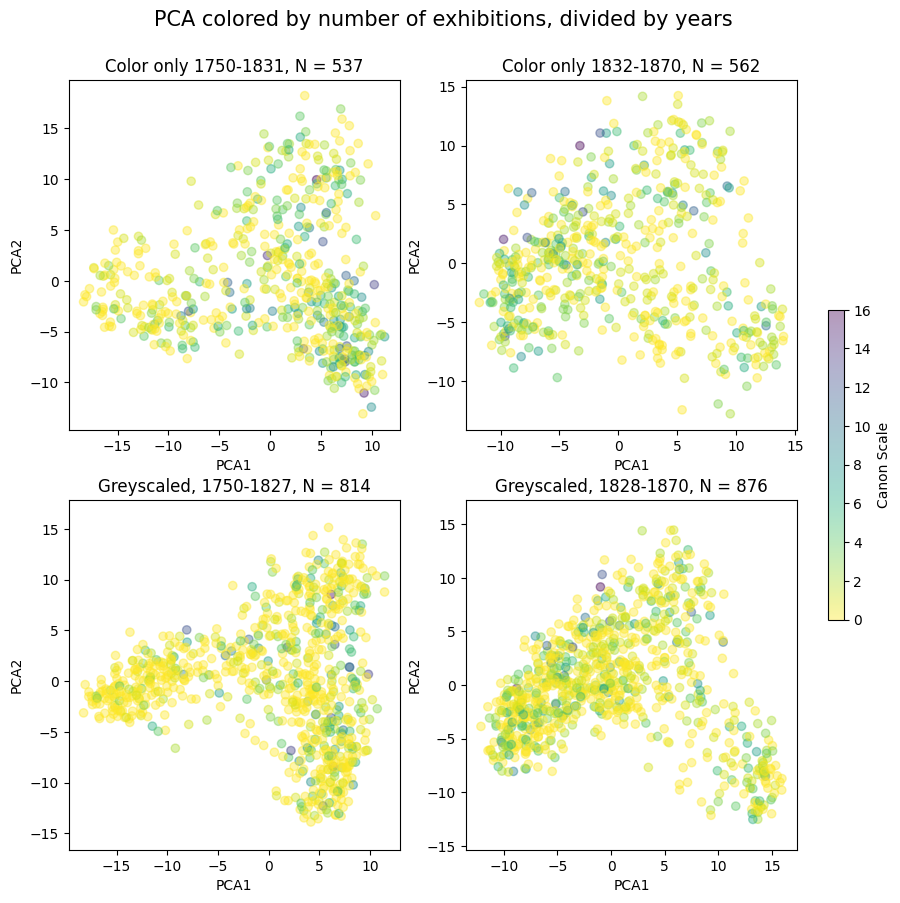

In [22]:
# PCA plots with canon scale
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sc1 = plot_pca_scale(axs[0,0], first_half_color_nona, 'embedding', "n_exhibitions", f"Color only 1750-1831, N = {len(first_half_color)}", cmap='viridis_r')
sc2 = plot_pca_scale(axs[0,1], second_half_color_nona, 'embedding', 'n_exhibitions', f"Color only 1832-1870, N = {len(second_half_color)}", cmap='viridis_r')
sc3 = plot_pca_scale(axs[1,0], first_half_grey_nona, 'grey_embedding', "n_exhibitions", f"Greyscaled, 1750-1827, N = {len(first_half_grey)}", cmap='viridis_r')
sc4 = plot_pca_scale(axs[1,1], second_half_grey_nona, 'grey_embedding', "n_exhibitions", f"Greyscaled, 1828-1870, N = {len(second_half_grey)}", cmap='viridis_r')

cbar = fig.colorbar(sc2, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label("Canon Scale")
fig.suptitle('PCA colored by number of exhibitions, divided by years', size = 15, y=0.95)

### Trying to make canon index by copying the formula by M. Tolonen et al. 

In [23]:
df['n_exhibitions'] = df['n_exhibitions'].fillna(0)

In [25]:
total_exb_count = df['n_exhibitions'].sum()

In [26]:
df['ex_years'] = df['ex_years'].fillna(0)
unique_years = [np.unique(years).tolist() for years in df['ex_years']]
df['unique_exb_years'] = unique_years

In [27]:
def canon_idx(row, total_exb_count):

    unique_exb_years = len(row['unique_exb_years'])

    idx = unique_exb_years * (row['n_exhibitions'] / total_exb_count)

    return idx

In [28]:
canon_idxes = [canon_idx(row, total_exb_count) for idx, row in df.iterrows()]
df['canon_idx'] = canon_idxes

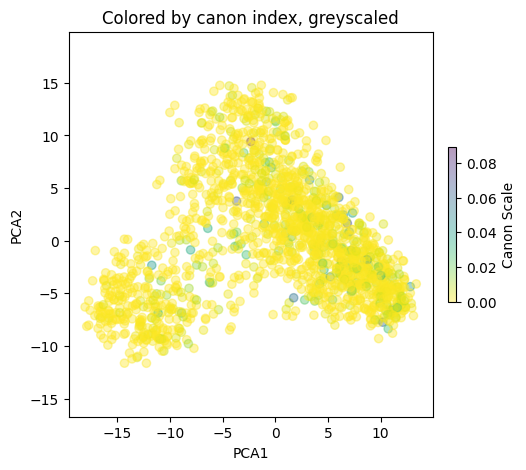

In [29]:
# PCA plots with canon scale
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

sc1 = plot_pca_scale(axs, df, 'grey_embedding', "canon_idx", f"Colored by canon index, greyscaled", cmap='viridis_r')

cbar = fig.colorbar(sc1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label("Canon Scale")

## Dendrograms

#### Exhibition canon (Exhibited or not)

In [30]:
def plot_dendrogram(df, col_to_color, col_to_label, embedding_col, l, h, palette='Set2'):
    
    import seaborn as sns

    df[col_to_color] = df[col_to_color].replace({0: 'other', 1: 'canon'})

    unique_categories = df[col_to_color].unique()

    # colors
    cat_map = dict(zip(df[col_to_label],df[col_to_color]))
    color_dict = {'other': '#129525', 'canon': '#356177'}#'#FCCA46'}

    # prepare data for plotting
    embeddings_matrix = np.stack(df[embedding_col].values)
    cosine_dist_matrix = cosine_distances(embeddings_matrix)
    
    if cosine_dist_matrix.shape[0] != cosine_dist_matrix.shape[1]:
        raise ValueError("Distance matrix is not square.")

    Z = linkage(cosine_dist_matrix, method='ward')

    # dendrogram plot
    sns.set_style('whitegrid')
    plt.figure(figsize=(l, h))
    dend = dendrogram(Z, orientation='top', no_labels=True, leaf_font_size=5, color_threshold=0, above_threshold_color='black')

    # Labels
    # get x-tick labels
    ax = plt.gca()
    xticklabels = ax.get_xticklabels()

    # apply colors labels
    used_colors = {}
    for tick in xticklabels:
        label = tick.get_text()
        # just to make sure we have no other labels in there
        if label in cat_map:
            value = cat_map[label]
            color = color_dict[value]
            tick.set_color(color)
            used_colors[value] = color
        else:
            tick.set_color('black')
    
    # update labels in used_colors, make titlecase
    used_colors = {k.replace('_', ' ').title(): v for k, v in used_colors.items()}
    # make "other" if O in used_colors
    if 'O' in used_colors:
        used_colors['Other'] = used_colors.pop('O')
    
    # layout
    plt.xlabel("Cosine Distance")

    legend_handles = [Patch(facecolor=color, label=label) for label, color in used_colors.items()]
    ax.legend(handles=legend_handles, loc='upper right', fontsize = 30)

    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()

In [31]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

In [40]:
def plot_bar_dendrogram(df, col_to_color, embedding_col, l, h):

    unique_categories = df[col_to_color].unique()

    #cat_map = dict(zip(df[embedding_col],df[col_to_color]))
    color_dict = {'other': '#129525', 'canon': '#356177'}#'#FCCA46'}
    lut = dict(zip(df[col_to_color].unique(), color_dict))
    col_colors = df[col_to_color].map(color_dict).to_numpy()

    # prepare data for plotting
    embeddings_matrix = np.stack(df[embedding_col].values)
    cosine_dist_matrix = cosine_distances(embeddings_matrix)

    if cosine_dist_matrix.shape[0] != cosine_dist_matrix.shape[1]:
        raise ValueError("Distance matrix is not square.")

    # calculate linkage matrix for hiearchical clustering
    Z = linkage(cosine_dist_matrix, method='ward')   

    # plot dendrogram
    sns.set_theme(color_codes=True)

    # Pass your linkage matrix using the `row_linkage` parameter
    g = sns.clustermap(
        embeddings_matrix,
        row_colors=col_colors,
        col_cluster=False,
        row_linkage=Z,  # <- your custom linkage here
        dendrogram_ratio=(.1, .1),
        colors_ratio=0.04,
        figsize=(l, h)
    )

       # Optional cleanup
    g.ax_heatmap.remove()
    g.cax.remove()
    g.ax_row_dendrogram.legend(
        #handles=[Rectangle((0, 0), 0, 0, color=val, label=key) for key, val in lut.items()],
        #title='Species',
        loc='lower left'
    )

    plt.show()


    ## Optional cleanup
    #g.ax_heatmap.remove()
    #g.cax.remove()
    #g.ax_row_dendrogram.legend(
        #handles=[Rectangle((0, 0), 0, 0, color=val, label=key) for key, val in lut.items()],
     #   title='Species',
     #   loc='lower left'
    #)

    #plt.show()

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from scipy.cluster.hierarchy import linkage
from matplotlib.patches import Patch

def plot_bar_dendrogram(df, col_to_color, embedding_col, l, h, title):
    
    # define colors for 'other' and 'canon' category
    color_dict = {'other': '#129525', 'canon': '#356177'}

    # map colors to canon variable
    col_colors = df[col_to_color].map(color_dict).to_numpy()

    # Prepare embeddings and distances
    embeddings_matrix = np.stack(df[embedding_col].values)
    cosine_dist_matrix = cosine_distances(embeddings_matrix)

    if cosine_dist_matrix.shape[0] != cosine_dist_matrix.shape[1]:
        raise ValueError("Distance matrix is not square.")

    # calculate linkage matrix for hiearchical clustering of painting embeddings
    Z = linkage(cosine_dist_matrix, method='ward')

    # create dendrogram
    # we are using seaborn to plot the colors as a bar
    # seaborn does however plot their dendrograms vertically, so we need to transpose the matrix and color by columns to plot horizontally 
    sns.set_theme(color_codes=True)

    g = sns.clustermap(
        embeddings_matrix.T, # transpose matrix so it's now (dimensions, paintings)
        col_colors=col_colors, # color by columns (i.e., canon category for painting)
        row_cluster=False,               
        col_linkage=Z, # use custom linkage matrix
        dendrogram_ratio=(0.01, 0.9), 
        colors_ratio=0.04,
        figsize=(l, h)
    )

    # remove heatmap (it's just a binary variable so not much information here)
    g.ax_heatmap.remove()
    g.cax.remove()

    # add legend
    handles = [Patch(color=color_dict[key], label=key) for key in color_dict]
    g.ax_col_dendrogram.legend(
        handles=handles,
        loc = 'upper right',
        fontsize = '10',
        facecolor = 'none', # remove grey background from legend box
        title= 'Canon label'
    )

    # adjust layot of plot
    plt.subplots_adjust(top=0.98, bottom=0.15, left=0.05, right=0.95, hspace=0.05)

    # axes are a bit messed up so I'm just adding a y axis manually using a text box
    g.fig.text(0.02, 0.6, "Cosine Distance", va='center', rotation='vertical', fontsize=12)
    
    # add title
    g.fig.suptitle(title, y=1, fontsize=16)

    plt.show()

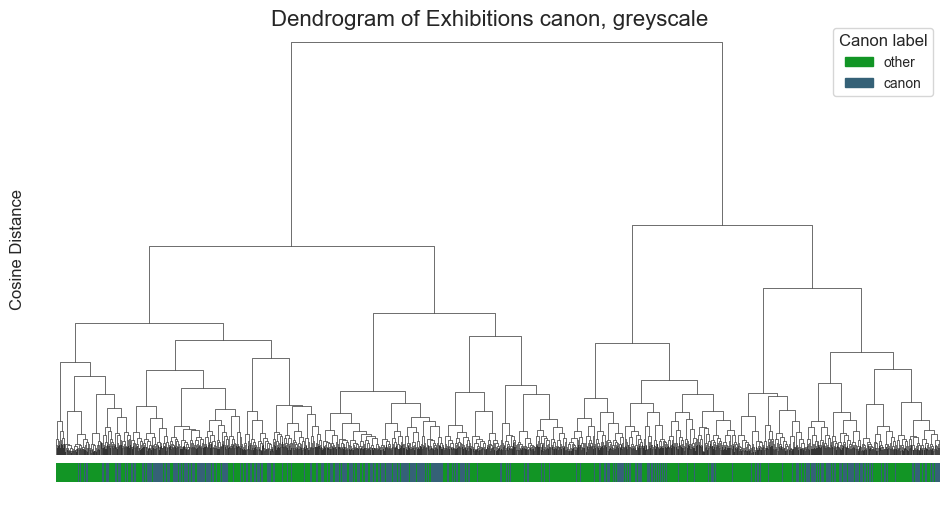

In [205]:
plot_bar_dendrogram(df, 'exb_canon', 'embedding', 10, 6, 'Dendrogram of Exhibitions canon, greyscale')

In [206]:
df.columns

Index(['smk_id', 'period', 'start_year', 'title', 'first_artist',
       'all_artists', 'num_artists', 'main_type', 'all_types',
       'image_thumbnail', 'gender', 'birth_death', 'nationality', 'history',
       'artist_roles', 'creator_roles', 'num_creators', 'techniques',
       'enrichment_url', 'content_person', 'has_text', 'colors',
       'geo_location', 'entropy', 'tags_en', 'image', 'rgb', 'exhibitions',
       'acquisition_date', 'responsible_department', 'documentation',
       'on_display', 'current_location_name', 'literary_reference',
       'object_history_note', 'exhibition_venues', 'smk_exhibitions',
       'golden_titles', 'exb_canon', 'docs_len', 'docs_canon', 'canon',
       'n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions', 'embedding',
       'grey_embedding', 'ex_years', 'ex_distances', 'smk_distances',
       'dist_canon', 'unique_exb_years', 'canon_idx'],
      dtype='object')

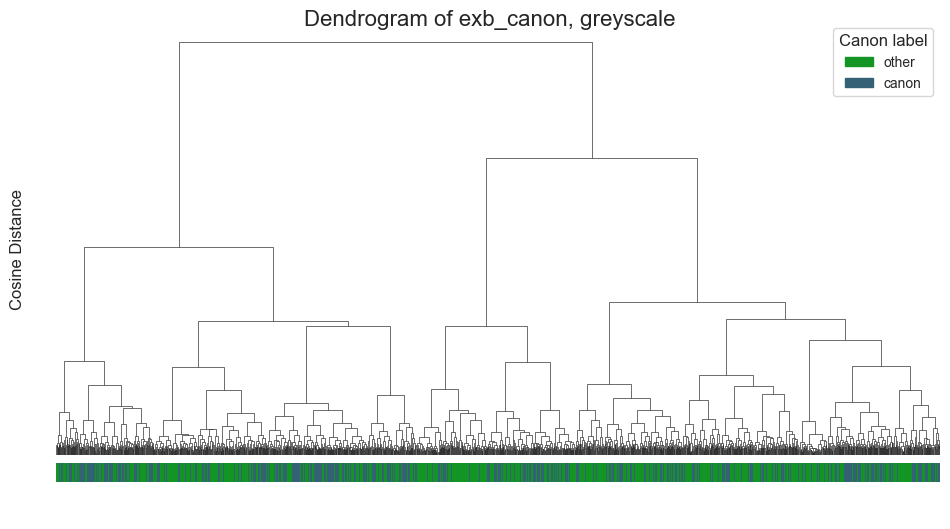

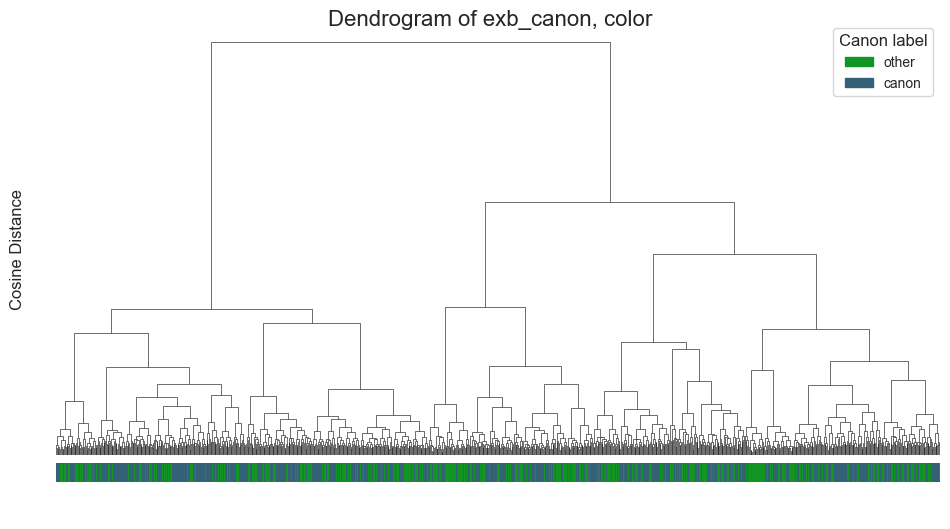

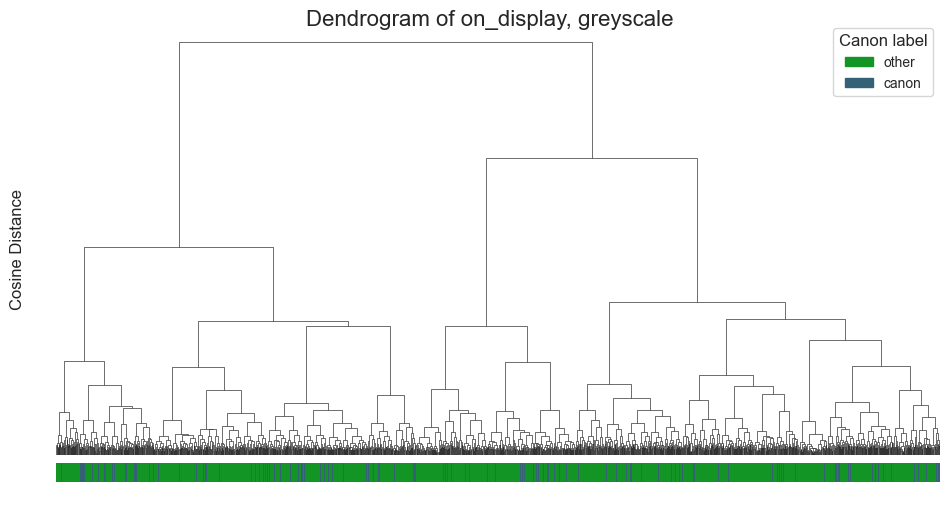

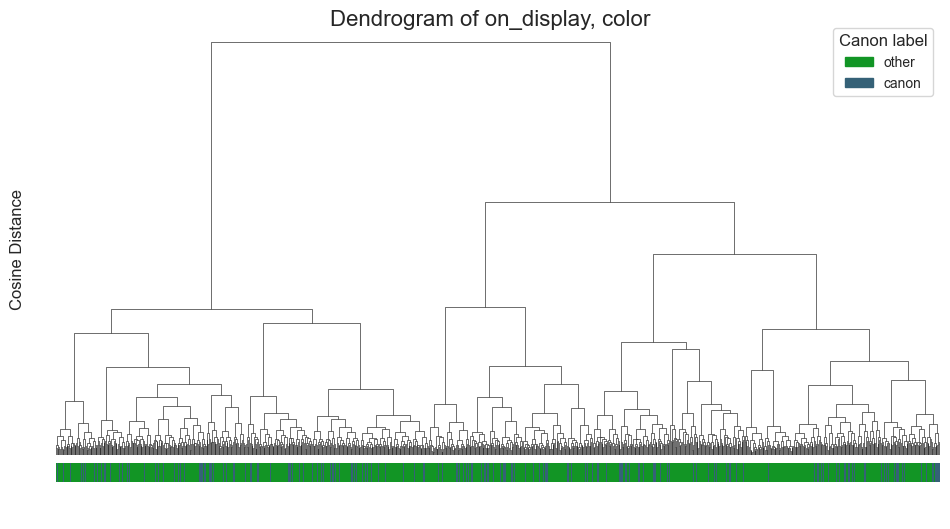

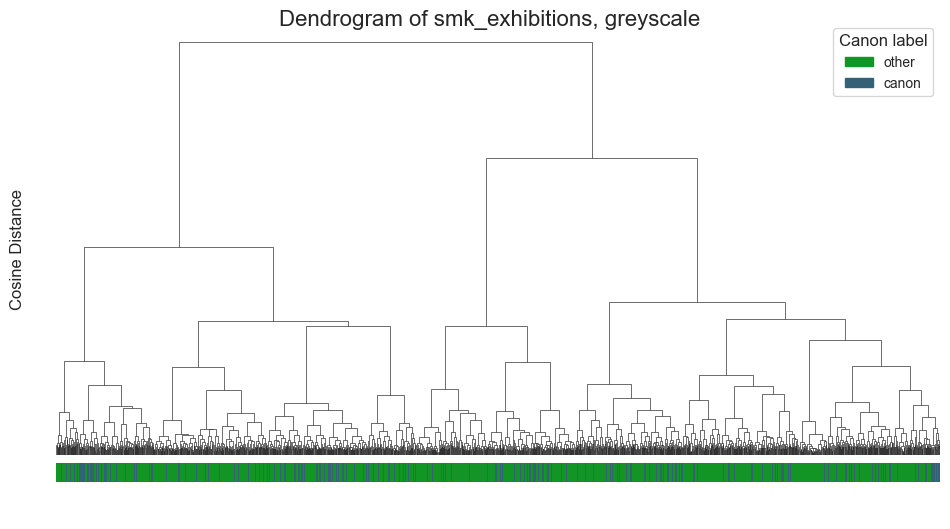

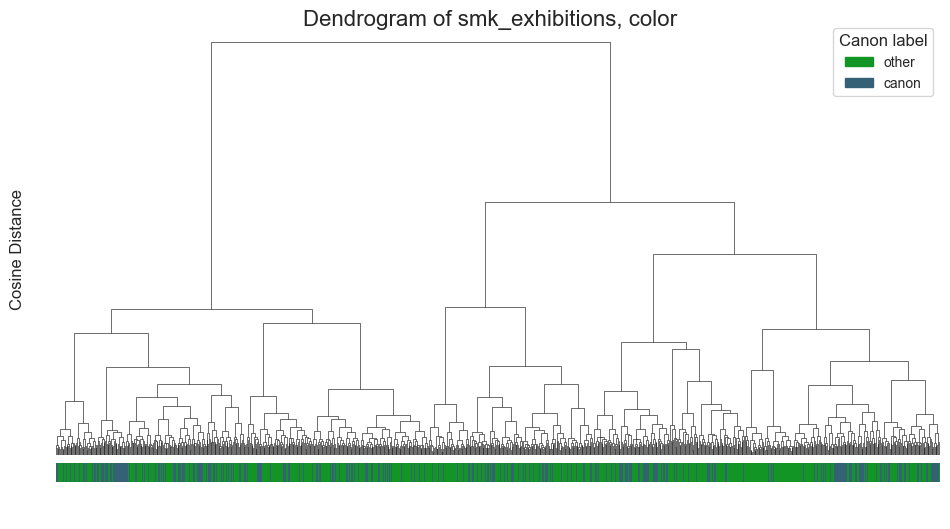

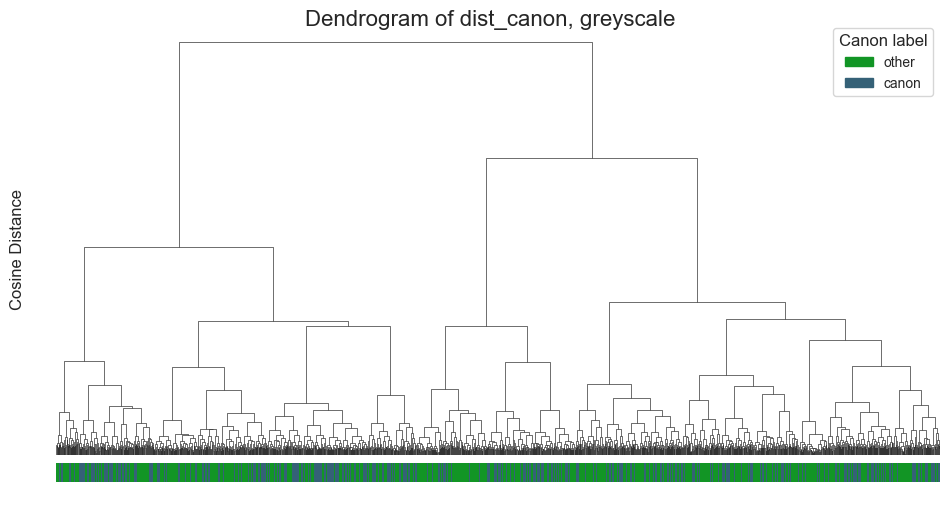

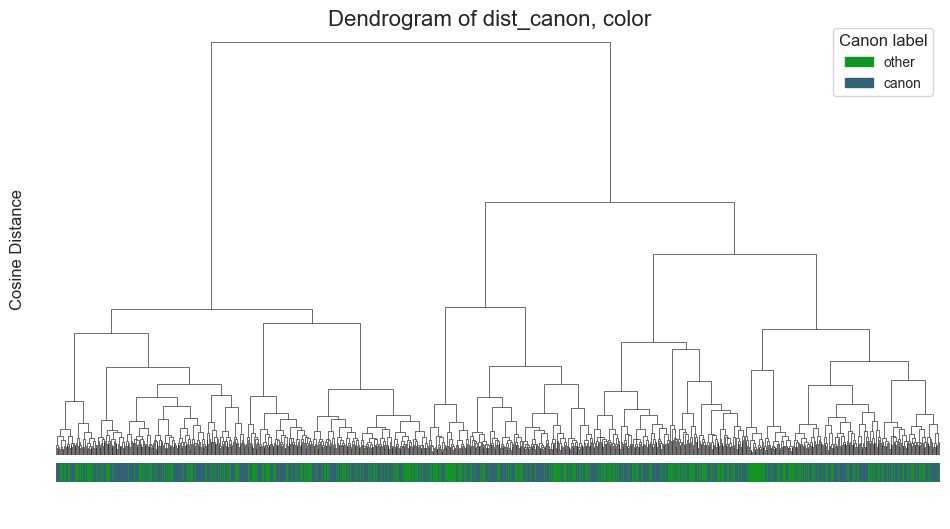

In [207]:
canon_cols = ['exb_canon', 'on_display', 'smk_exhibitions', 'dist_canon']

for col in canon_cols:

    # plot greyscale
    plot_bar_dendrogram(df, col, 'grey_embedding', 10, 6, f'Dendrogram of {col}, greyscale')

    # plot color
    plot_bar_dendrogram(color_subset, col, 'embedding', 10, 6, f'Dendrogram of {col}, color')

# Measuring diachronic change

#### Naive approach (no up or downsampling)

In [272]:
def get_cosim_mean_std(groups_dict, embedding_col, key):

    '''
    Calculate mean and SD cosine similarity for embedding column of dataset in groups_dict
    '''

    data = groups_dict[key]
    embeddings = np.stack(data[embedding_col].values)
    mean_cosim = cosine_similarity(embeddings).mean()
    std_cosim = cosine_similarity(embeddings).std()
    
    return mean_cosim, std_cosim

In [273]:
def create_groups(df, year_col, canon_col, year_range):

    '''
    Create dict with groups of canon, non-canon and total paintings in specified time window
    '''
    
    canon = df.loc[(df[year_col].isin(year_range)) & (df[canon_col] == 'canon')]
    df_total = df.loc[df[year_col].isin(year_range)]
    non_canon = df.loc[(df[year_col].isin(year_range)) & (df[canon_col] == 'other')]

     # create dict
    groups = {'canon': canon, 'df_total': df_total, 'non_canon': non_canon}

    return groups

In [274]:
def get_all_cosims(df, year_col, canon_col, year_range, embedding_col, sampling, sample_size, run):

    '''
    Calculate all cosine similarity measures for current time window and return as dict. 

    First creates groups of canon, non-canon and total paintings in the current time window.
    Next, it calculates the mean cosine similarity of the embeddings in the current window for each group.
    The cosine similarity between the mean canon and non-canon embeddings is also calculated.
    '''

    groups = create_groups(df, year_col, canon_col, year_range)

    if sampling == True:
        for key in groups:
            group = groups[key]
            groups[key] = group.sample(sample_size, random_state=run) if len(group) > sample_size else group

    # get the mean embeddings of the current window for each group
    canon_mean = groups['canon'][embedding_col].mean(axis=0)
    non_canon_mean = groups['non_canon'][embedding_col].mean(axis=0)

    temp = {} 

    # get the mean cosine similarity between mean canon embedding and mean non-canon embedding for this time window
    
    #canon_noncanon_similarity = cosine_similarity(np.stack([non_canon_mean, canon_mean])).mean()
    canon_noncanon_similarity = cosine_similarity(np.stack([non_canon_mean, canon_mean]))[0][1]
    temp['CANON_NONCANON_COSIM'] = canon_noncanon_similarity

    # get mean cosine similarity of canon embeddings for this time window
    canon_mean, canon_std = get_cosim_mean_std(groups, embedding_col, 'canon')
    temp['CANON_COSIM_MEAN'] = canon_mean 
    temp['CANON_COSIM_STD'] = canon_std

    # get mean cosine similarity of non-canon embeddings for this time window
    nc_mean, nc_std = get_cosim_mean_std(groups, embedding_col, 'non_canon')
    temp['NONCANON_COSIM_MEAN'] = nc_mean
    temp['NONCANON_COSIM_STD'] = nc_std

    # get mean cosine similarity of all data for this time window
    t_mean, t_std = get_cosim_mean_std(groups, embedding_col, 'df_total')
    temp['TOTAL_COSIM_MEAN'] = t_mean
    temp['TOTAL_COSIM_STD'] = t_std

    temp['n_paintings'] = [len(groups['df_total']), len(groups['canon']), len(groups['non_canon'])]
    
    return temp


In [275]:
# sampling 

# intra-group
def simulate_cosim_mean_std(groups, key, embedding_col, num_simulations, sim_type='gaussian'):
        
        # get data for canon group
        data = groups[key]
        
        if len(data) > 1:

            embeddings = np.stack(data[embedding_col].values)
            cosim_matrix = cosine_similarity(embeddings)

            # exclude the diagonal of the matrix
            cosim_values = cosim_matrix[np.triu_indices_from(cosim_matrix, k=1)]


            if sim_type == 'gaussian':
                simulated_means = []

                for _ in range(num_simulations):

                    # Simulate data from a normal distribution based on the sample mean and std
                    simulated_data = np.random.normal(cosim_values.mean(), cosim_values.std(), len(cosim_values))
                    simulated_means.append(simulated_data.mean())

                # return the mean of the simulated means as the 'overall' cosim mean for this time window and group
                return np.mean(simulated_means), np.std(simulated_means)
            
            elif sim_type == 'bootstrap':
                bootstrap_means = []
                for _ in range(num_simulations):

                    # Generate a bootstrap sample (randomly sample from cosim_values) with replacement (each value can appear multiple times)
                    bootstrap_sample = resample(cosim_values)
                    
                    # Calculate the mean of the bootstrap sample
                    bootstrap_mean = np.mean(bootstrap_sample)

                    bootstrap_means.append(bootstrap_mean)

                return np.mean(bootstrap_means), np.std(bootstrap_means)
            
            else:
                print('simulation type not defined')
        else:
            return np.nan, np.nan

In [276]:
# INTERGROUP

def simulate_cosim_between_groups(df, key1, key2, num_simulations, sim_type='gaussian'):
    
    # Get embeddings for each group (canon vs non canon)
    data1 = df[key1]
    data2 = df[key2]
    
    if len(data1) > 1 and len(data2) > 1:
        embeddings1 = np.stack(data1['embedding'].values)
        embeddings2 = np.stack(data2['embedding'].values)

        mean_emb1_list = []
        mean_emb2_list = []

        if sim_type == 'gaussian':
            for _ in range(num_simulations):

                # Simulate embeddings from normal distribution based on mean and std of embeddings
                simulated_embedding1 = np.random.normal(embeddings1.mean(), embeddings1.std(), embeddings1.shape)
                simulated_embedding2 = np.random.normal(embeddings2.mean(), embeddings2.std(), embeddings2.shape)
                
                # Calculate mean embedding from each simulation
                mean_embedding1 = np.mean(simulated_embedding1, axis=0)
                mean_embedding2 = np.mean(simulated_embedding2, axis=0)

                # mean embedding 1 and 2
                mean_emb1_list.append(mean_embedding1)
                mean_emb2_list.append(mean_embedding2)
            
            # get overall mean of all simulation runs for each group
            # so i get two means
            overall_mean1 = np.mean(mean_emb1_list, axis=0)
            overall_mean2 = np.mean(mean_emb2_list, axis=0)

            # # Calculate cosine similarity between the mean embeddings
            similarity = cosine_similarity([overall_mean1], [overall_mean2])

            return similarity
        
        elif sim_type == 'bootstrap':
            for _ in range(num_simulations):
                # Sample with replacement from both groups independently
                bootstrap_sample1 = resample(embeddings1)
                bootstrap_sample2 = resample(embeddings2)
                
                # Calculate mean embeddings for each bootstrap sample
                mean_embedding1 = np.mean(bootstrap_sample1, axis=0)
                mean_embedding2 = np.mean(bootstrap_sample2, axis=0)

                # mean embedding 1 and 2
                mean_emb1_list.append(mean_embedding1)
                mean_emb2_list.append(mean_embedding2)
            
            # get overall mean of all simulation runs for each group
            # so i get two means
            overall_mean1 = np.mean(mean_emb1_list, axis=0)
            overall_mean2 = np.mean(mean_emb2_list, axis=0)

            # # Calculate cosine similarity between the mean embeddings
            similarity = cosine_similarity([overall_mean1], [overall_mean2])

            return similarity
        
        else:
            print('simulation type not defined')
    else:
        return np.nan 

In [277]:
def simulate_all_cosims(df, year_col, canon_col, year_range, embedding_col, sampling, sample_size, run, num_simulations, sim_type):

    '''
    Calculate all cosine similarity measures for current time window and return as dict. 

    First creates groups of canon, non-canon and total paintings in the current time window.
    Next, it calculates the mean cosine similarity of the embeddings in the current window for each group.
    The cosine similarity between the mean canon and non-canon embeddings is also calculated.
    '''

    groups = create_groups(df, year_col, canon_col, year_range)

    if sampling == True:
        for key in groups:
            group = groups[key]
            groups[key] = group.sample(sample_size, random_state=run) if len(group) > sample_size else group

    temp = {} 

    canon_mean, canon_std = simulate_cosim_mean_std(groups, 'canon', embedding_col, num_simulations, sim_type)
    temp['CANON_COSIM_MEAN'] = canon_mean 
    temp['CANON_COSIM_STD'] = canon_std

    # get mean cosine similarity of non-canon embeddings for this time window
    nc_mean, nc_std = simulate_cosim_mean_std(groups, 'non_canon', embedding_col, num_simulations, sim_type)
    temp['NONCANON_COSIM_MEAN'] = nc_mean
    temp['NONCANON_COSIM_STD'] = nc_std

    # get mean cosine similarity of all data for this time window
    t_mean, t_std = simulate_cosim_mean_std(groups, 'df_total', embedding_col, num_simulations, sim_type)
    temp['TOTAL_COSIM_MEAN'] = t_mean
    temp['TOTAL_COSIM_STD'] = t_std

    # get the mean cosine similarity between mean canon embedding and mean non-canon embedding for this time window
    #canon_noncanon_similarity = cosine_similarity(np.stack([non_canon_mean, canon_mean])).mean()
    #canon_noncanon_similarity = cosine_similarity(np.stack([non_canon_mean, canon_mean]))[0][1]
    #temp['CANON_NONCANON_COSIM'] = canon_noncanon_similarity

    # Intergroup similarity calculations
    mean_similarity_c_nc = simulate_cosim_between_groups(groups, 'canon', 'non_canon', num_simulations, sim_type)
    temp['CANON_NONCANON_COSIM'] = mean_similarity_c_nc


    temp['n_paintings'] = [len(groups['df_total']), len(groups['canon']), len(groups['non_canon'])]
    
    return temp

In [279]:
def run_change_analysis(w_size, step_size, df, year_col, simulate, canon_col, embedding_col, n_runs, sampling, sample_size, num_simulations, sim_type):

    # raise error if w size is smaller than 5
    # Start a loop over the years
    mean_similarity_dict = {}

    # Get the minimum and maximum years in the dataset
    min_year = df[year_col].min()
    max_year = df[year_col].max()

    for run in range(n_runs):
        for start_year in range(min_year, max_year - w_size + 1, step_size):

            # Define rolling window range for each window
            year_range = list(range(start_year, start_year + w_size))
            range_label = f"{year_range[0]}-{year_range[-1]}"

            if simulate == True:
                temp = simulate_all_cosims(df, year_col, canon_col, year_range, embedding_col, sampling, sample_size, run, num_simulations, sim_type)

            else:
                temp = get_all_cosims(df, year_col, canon_col, year_range, embedding_col, sampling, sample_size, run)
            
            # add cosine similarity measure to dict for dict at time window
            mean_similarity_dict[range_label] = temp
    
    # create dataframe from dict
    sim_df = pd.DataFrame.from_dict(mean_similarity_dict, orient='index').reset_index()
    sim_df = sim_df.rename(columns={"index": "year_RANGE"})

    # add start year column
    sim_df['START_year'] = sim_df['year_RANGE'].apply(lambda x: int(x.split('-')[0]))

    # make sure there's at least 2 paintings in each group
    print(sim_df['n_paintings'].apply(lambda x: min(x)).min(), "is the smallest group size in a window")

    return sim_df

In [283]:
def plot_diachronic_change(w_size:int, step_size:int, df:pd.DataFrame, year_col:str, simulate:bool, canon_col:str, embedding_col:str, n_runs:int, sampling:bool, sample_size:int, num_simulations:int, sim_type:str, cutoff:int, cosim_to_plot:str, ax:int, color:str):

    plt.style.use('default')

    # get dataframe of cosine similarity for each time window for chosen canon measure 
    sim_df = run_change_analysis(w_size, step_size, df, year_col, simulate, canon_col, embedding_col, n_runs, sampling, sample_size, num_simulations, sim_type)
    
    # remove first n and last n windows
    sim_df = sim_df.iloc[cutoff:-cutoff]

    # get correlation between year and cosine similarity
    corr, pval = spearmanr(sim_df['START_year'], sim_df[cosim_to_plot])

    # plot change over time
    ax.plot(sim_df['START_year'], sim_df[cosim_to_plot], color=color, linewidth=2, alpha=0.7)

    if pval < 0.01:
        greater_dir = '<'
    else:
        greater_dir = '>'

    col_or_grey = 'colored' if embedding_col == 'embedding' else 'greyscaled'

    simulated = f' {sim_type} simulated n = {num_simulations}' if simulate == True else ''

    ylabel = 'Mean Cosine Similarity'

    if cosim_to_plot == 'CANON_NONCANON_COSIM':
        ax.set_title(f'{canon_col} vs non-canon{simulated}, {col_or_grey}, r = {round(corr, 2)}, p{greater_dir}0.1')
        ylabel = 'Cosine Similarity'

    elif cosim_to_plot == 'TOTAL_COSIM_MEAN':
        ax.set_title(f'Total data, {col_or_grey}, r = {round(corr, 2)}, p{greater_dir}0.1')

    else:
        ax.set_title(f'{canon_col}{simulated}, {col_or_grey}, r = {round(corr, 2)}, p{greater_dir}0.1')

    # create plot
    ax.set_xlabel(year_col)
    ax.set_ylabel(ylabel)

In [281]:
from sklearn.utils import resample

47 is the smallest group size in a window
52 is the smallest group size in a window
26 is the smallest group size in a window
26 is the smallest group size in a window
25 is the smallest group size in a window
27 is the smallest group size in a window
47 is the smallest group size in a window
52 is the smallest group size in a window


Text(0.5, 0.97, 'Intra-group analysis for all canon variables, w_size = 30')

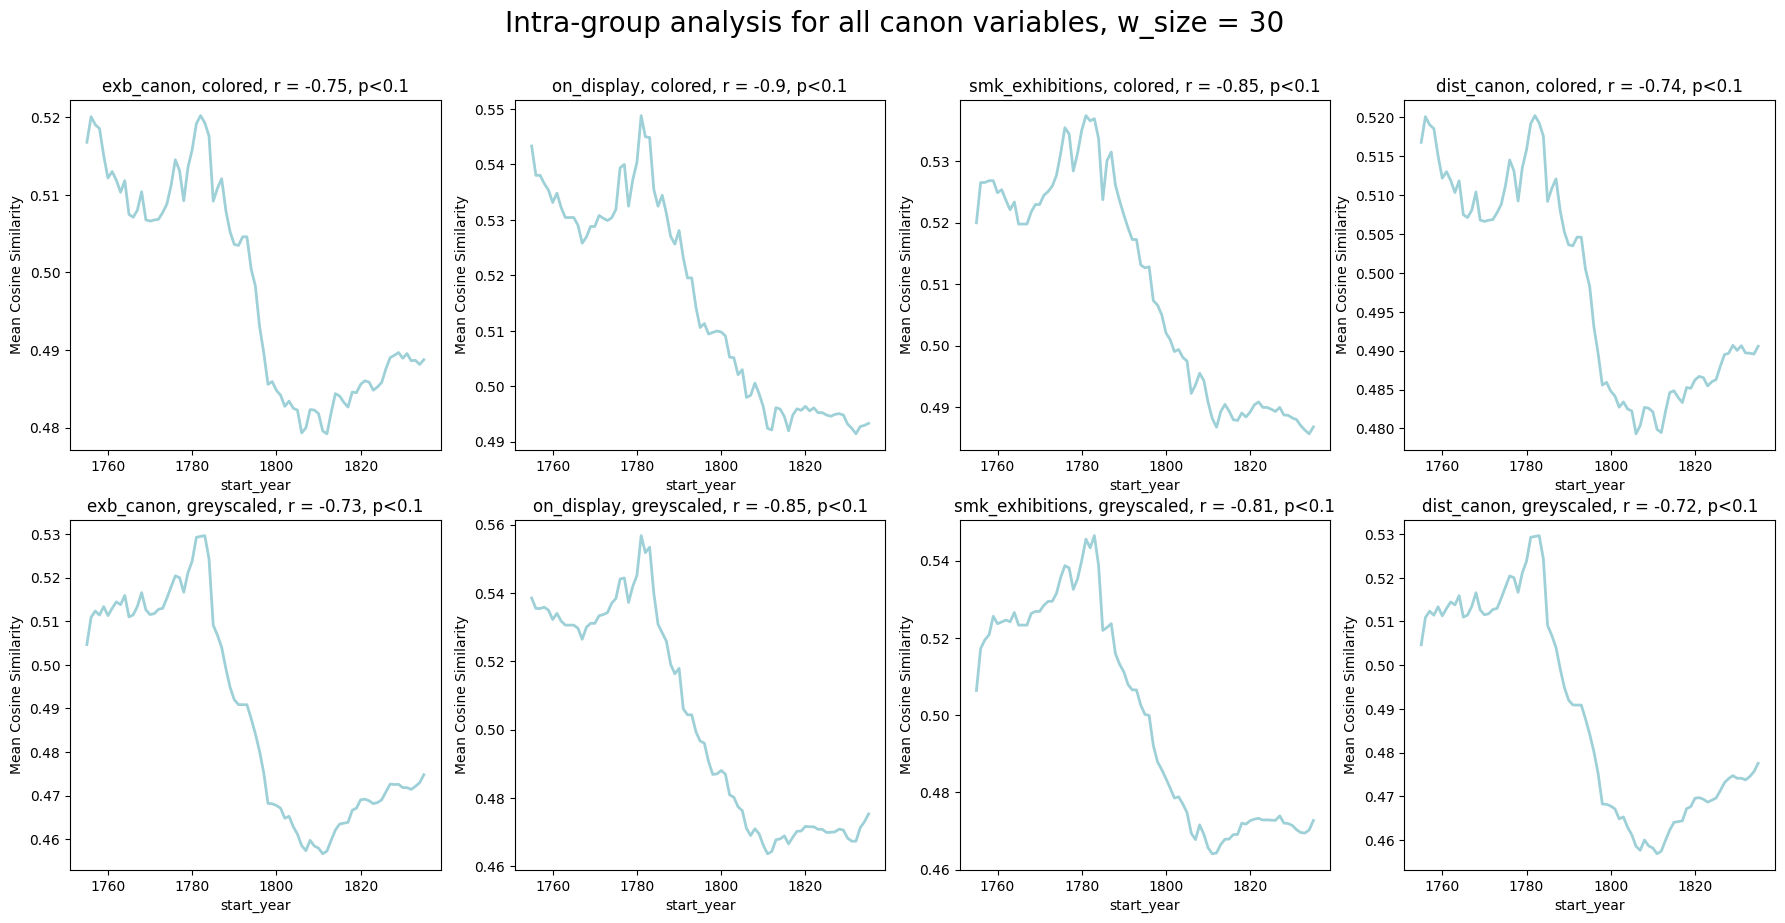

In [287]:
# create subplots
fig, axs = plt.subplots(2, 4, figsize=(22, 10))

for idx, col in enumerate(canon_cols):
    # plot color
    plot_diachronic_change(w_size = 30, 
                           step_size = 1, 
                           df = color_subset, 
                           year_col = 'start_year', 
                           simulate = False, 
                           canon_col = col, 
                           embedding_col = 'embedding', 
                           n_runs = 1, 
                           sampling = False, 
                           sample_size = 0,
                           num_simulations = 0, 
                           sim_type = 'none', 
                           cutoff = 5, 
                           cosim_to_plot = 'CANON_COSIM_MEAN', 
                           ax = axs[0, idx], 
                           color ='#75BCC6')
    
    # plot greyscale
    plot_diachronic_change(w_size = 30, 
                           step_size = 1, 
                           df = df, 
                           year_col = 'start_year', 
                           simulate = False, 
                           canon_col = col, 
                           embedding_col = 'grey_embedding', 
                           n_runs = 1, 
                           sampling = False, 
                           sample_size = 0,
                           num_simulations = 0, 
                           sim_type = 'none', 
                           cutoff = 5, 
                           cosim_to_plot = 'CANON_COSIM_MEAN', 
                           ax = axs[1, idx], 
                           color ='#75BCC6')


fig.suptitle('Intra-group analysis for all canon variables, w_size = 30', size = 20, y=0.97)

#### Intra-group analysis with gaussian sampling

In [ ]:
# create subplots
fig, axs = plt.subplots(2, 4, figsize=(22, 10))

for idx, col in enumerate(canon_cols):
    # plot color
    plot_diachronic_change(w_size = 30, 
                           step_size = 1, 
                           df = color_subset, 
                           year_col = 'start_year', 
                           simulate = True, 
                           canon_col = col, 
                           embedding_col = 'embedding', 
                           n_runs = 1, 
                           sampling = False, 
                           sample_size = 0,
                           num_simulations = 1000, 
                           sim_type = 'gaussian', 
                           cutoff = 5, 
                           cosim_to_plot = 'CANON_COSIM_MEAN', 
                           ax = axs[0, idx], 
                           color ='#75BCC6')
    
    # plot greyscale
    plot_diachronic_change(w_size = 30, 
                           step_size = 1, 
                           df = df, 
                           year_col = 'start_year', 
                           simulate = True, 
                           canon_col = col, 
                           embedding_col = 'grey_embedding', 
                           n_runs = 1, 
                           sampling = False, 
                           sample_size = 0,
                           num_simulations = 1000, 
                           sim_type = 'gaussian', 
                           cutoff = 5, 
                           cosim_to_plot = 'CANON_COSIM_MEAN', 
                           ax = axs[1, idx], 
                           color ='#75BCC6')


fig.suptitle('Intra-group analysis for all canon variables with gaussian simulations, w_size = 30', size = 20, y=0.97)

#### Plot intra-group analysis

47 is the smallest group size in a window
52 is the smallest group size in a window
26 is the smallest group size in a window
26 is the smallest group size in a window
25 is the smallest group size in a window
27 is the smallest group size in a window
47 is the smallest group size in a window
52 is the smallest group size in a window


Text(0.5, 0.97, 'Intra-group analysis for all canon variables, w_size = 30')

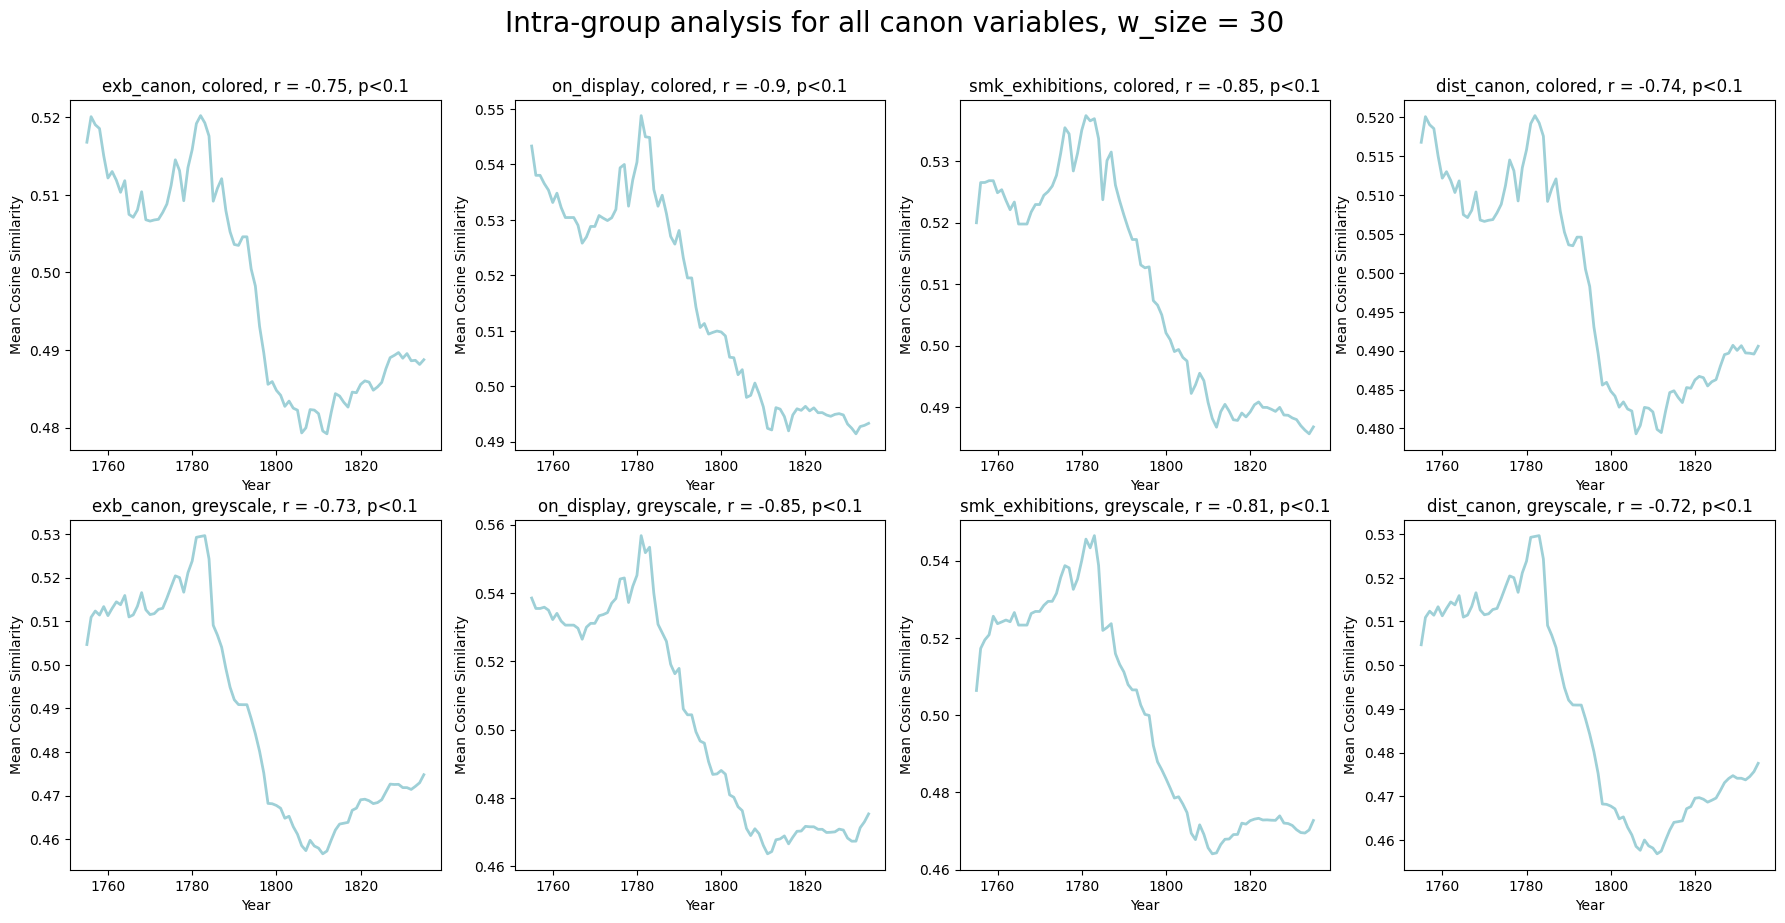

In [234]:
# create subplots
fig, axs = plt.subplots(2, 4, figsize=(22, 10))

for idx, col in enumerate(canon_cols):
    # plot color
    plot_diachronic_change(w_size = 30,
                           step_size= 1, 
                           df = color_subset, 
                           year_col = 'start_year',
                           canon_col = col, 
                           embedding_col = 'embedding', 
                           n_runs = 1, 
                           sampling = False, 
                           cutoff = 5,
                           cosim_to_plot='CANON_COSIM_MEAN',
                           ax = axs[0,idx], 
                           color = '#75BCC6',
                           title = f'{col}, colored', 
                           y_label= 'Mean Cosine Similarity')
    
    # plot greyscale
    plot_diachronic_change(w_size = 30,
                           step_size= 1, 
                           df = df, 
                           year_col = 'start_year',
                           canon_col = col, 
                           embedding_col = 'grey_embedding', 
                           n_runs = 1, 
                           sampling = False, 
                           cutoff = 5,
                           cosim_to_plot='CANON_COSIM_MEAN',
                           ax = axs[1,idx], 
                           color = '#75BCC6',
                           title = f'{col}, greyscale', 
                           y_label= 'Mean Cosine Similarity')

fig.suptitle('Intra-group analysis for all canon variables, w_size = 30', size = 20, y=0.97)

### Total intra-group

47 is the smallest group size in a window
52 is the smallest group size in a window


Text(0.5, 0.97, 'Intra-group analysis for total data, w_size = 30')

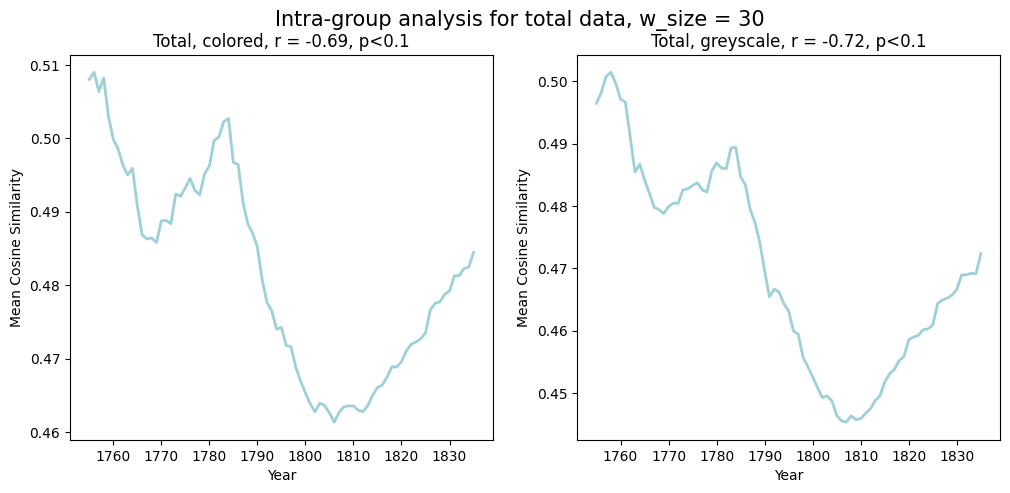

In [238]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# plot color
plot_diachronic_change(w_size = 30,
                        step_size= 1, 
                        df = color_subset, 
                        year_col = 'start_year',
                        canon_col = 'exb_canon', 
                        embedding_col = 'embedding', 
                        n_runs = 1, 
                        sampling = False, 
                        cutoff = 5,
                        cosim_to_plot='TOTAL_COSIM_MEAN',
                        ax = axs[0], 
                        color = '#75BCC6',
                        title = 'Total, colored', 
                        y_label= 'Mean Cosine Similarity')
    
# plot greyscale
plot_diachronic_change(w_size = 30,
                        step_size= 1, 
                        df = df, 
                        year_col = 'start_year',
                        canon_col = 'exb_canon', 
                        embedding_col = 'grey_embedding', 
                        n_runs = 1, 
                        sampling = False, 
                        cutoff = 5,
                        cosim_to_plot='TOTAL_COSIM_MEAN',
                        ax = axs[1], 
                        color = '#75BCC6',
                        title = 'Total, greyscale', 
                        y_label= 'Mean Cosine Similarity')

fig.suptitle('Intra-group analysis for total data, w_size = 30', size = 15, y=0.97)

#### Plot inter-group analysis

47 is the smallest group size in a window
52 is the smallest group size in a window
26 is the smallest group size in a window
26 is the smallest group size in a window
25 is the smallest group size in a window
27 is the smallest group size in a window
47 is the smallest group size in a window
52 is the smallest group size in a window


Text(0.5, 0.97, 'Inter-group analysis for all canon variables, w_size = 30')

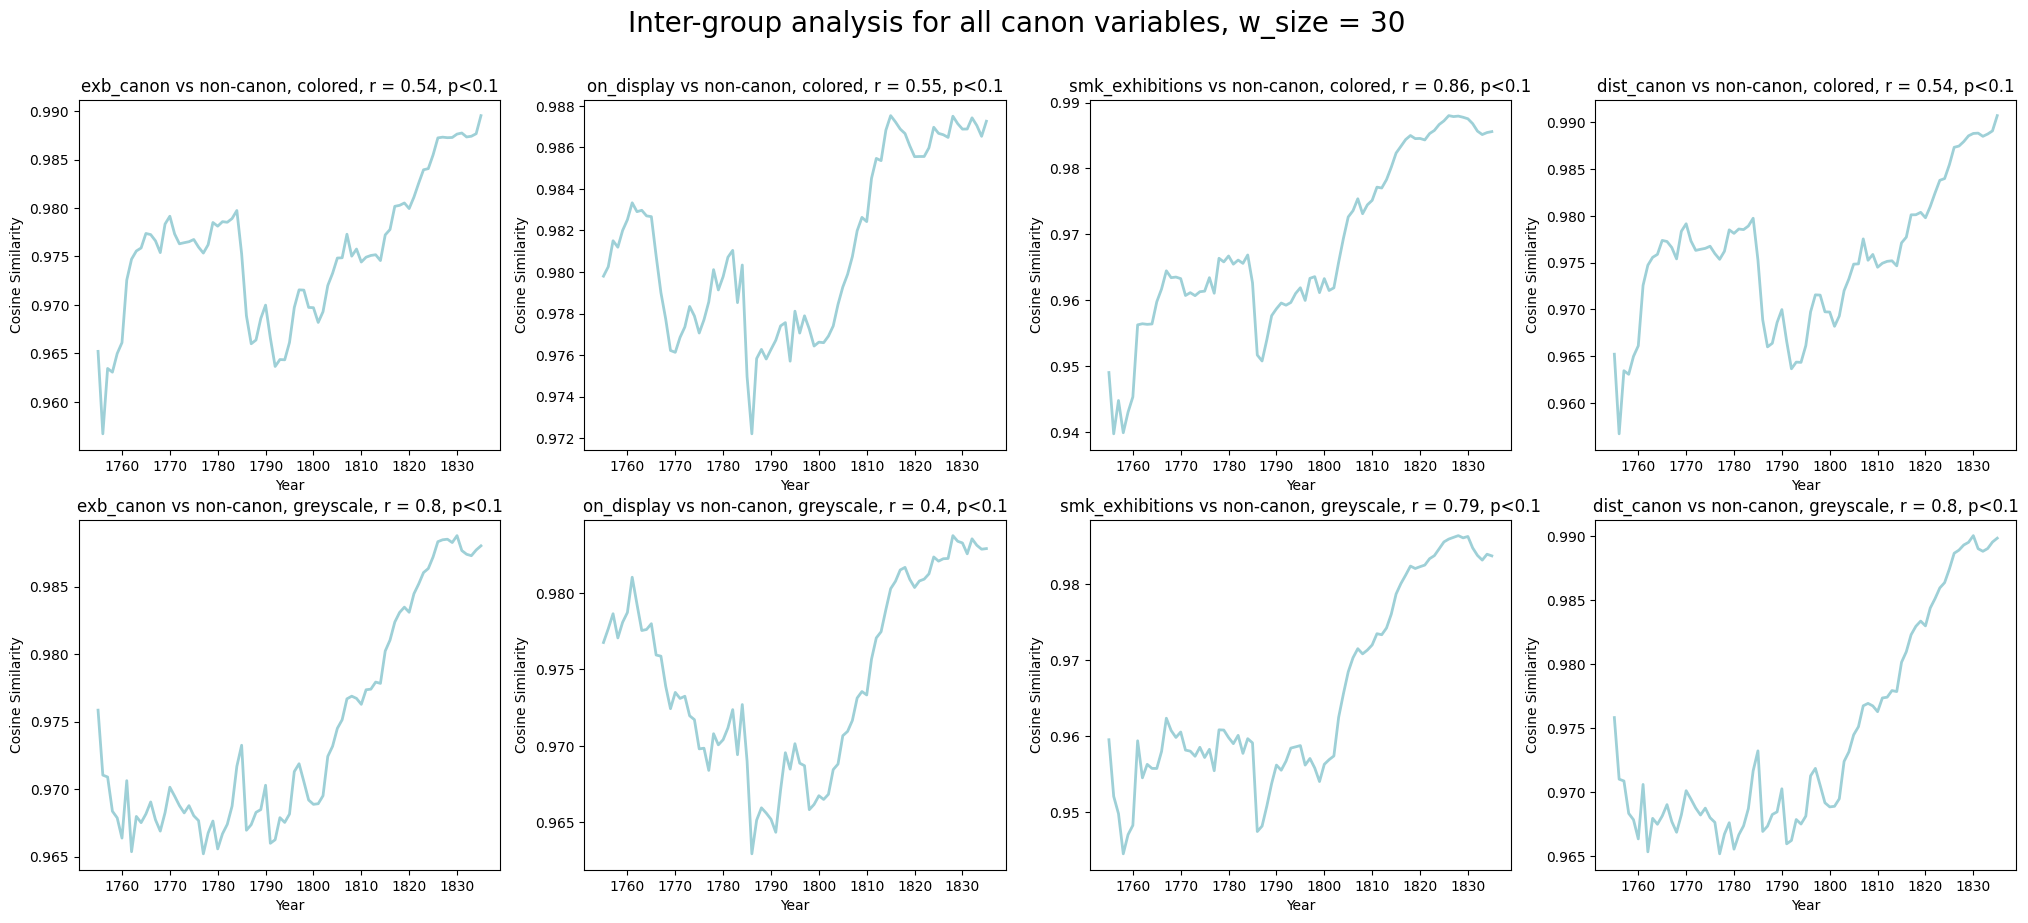

In [240]:
# create subplots
fig, axs = plt.subplots(2, 4, figsize=(25, 10))

for idx, col in enumerate(canon_cols):
    # plot color
    plot_diachronic_change(w_size = 30,
                           step_size= 1, 
                           df = color_subset, 
                           year_col = 'start_year',
                           canon_col = col, 
                           embedding_col = 'embedding', 
                           n_runs = 1, 
                           sampling = False, 
                           cutoff = 5,
                           cosim_to_plot='CANON_NONCANON_COSIM',
                           ax = axs[0,idx], 
                           color = '#75BCC6',
                           title = f'{col} vs non-canon, colored', 
                           y_label= 'Cosine Similarity')
    
    # plot greyscale
    plot_diachronic_change(w_size = 30,
                           step_size= 1, 
                           df = df, 
                           year_col = 'start_year',
                           canon_col = col, 
                           embedding_col = 'grey_embedding', 
                           n_runs = 1, 
                           sampling = False, 
                           cutoff = 5,
                           cosim_to_plot='CANON_NONCANON_COSIM',
                           ax = axs[1,idx], 
                           color = '#75BCC6',
                           title = f'{col} vs non-canon, greyscale', 
                           y_label= 'Cosine Similarity')

fig.suptitle('Inter-group analysis for all canon variables, w_size = 30', size = 20, y=0.97)

##### Change to w_size = 10

9 is the smallest group size in a window
12 is the smallest group size in a window
3 is the smallest group size in a window
3 is the smallest group size in a window
5 is the smallest group size in a window
5 is the smallest group size in a window
9 is the smallest group size in a window
12 is the smallest group size in a window


Text(0.5, 0.97, 'Intra-group analysis for all canon variables, w_size = 10')

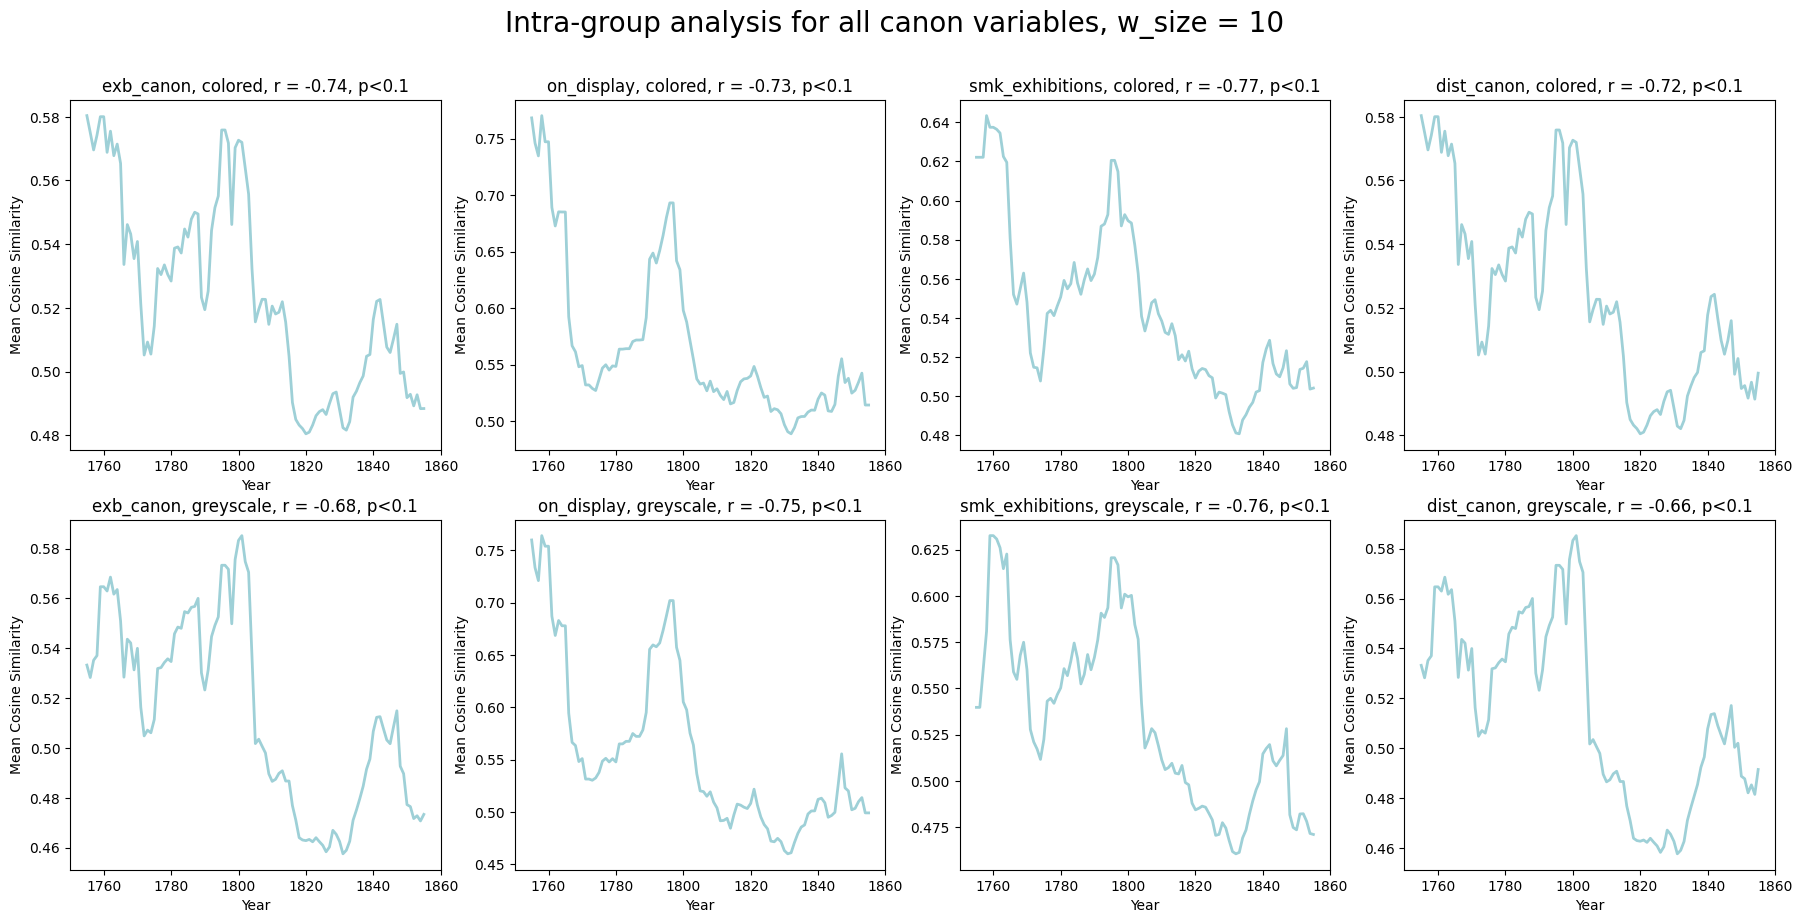

In [241]:
# create subplots
fig, axs = plt.subplots(2, 4, figsize=(22, 10))

for idx, col in enumerate(canon_cols):
    # plot color
    plot_diachronic_change(w_size = 10,
                           step_size= 1, 
                           df = color_subset, 
                           year_col = 'start_year',
                           canon_col = col, 
                           embedding_col = 'embedding', 
                           n_runs = 1, 
                           sampling = False, 
                           cutoff = 5,
                           cosim_to_plot='CANON_COSIM_MEAN',
                           ax = axs[0,idx], 
                           color = '#75BCC6',
                           title = f'{col}, colored', 
                           y_label= 'Mean Cosine Similarity')
    
    # plot greyscale
    plot_diachronic_change(w_size = 10,
                           step_size= 1, 
                           df = df, 
                           year_col = 'start_year',
                           canon_col = col, 
                           embedding_col = 'grey_embedding', 
                           n_runs = 1, 
                           sampling = False, 
                           cutoff = 5,
                           cosim_to_plot='CANON_COSIM_MEAN',
                           ax = axs[1,idx], 
                           color = '#75BCC6',
                           title = f'{col}, greyscale', 
                           y_label= 'Mean Cosine Similarity')

fig.suptitle('Intra-group analysis for all canon variables, w_size = 10', size = 20, y=0.97)

9 is the smallest group size in a window
12 is the smallest group size in a window


Text(0.5, 0.97, 'Intra-group analysis for total data, w_size = 10')

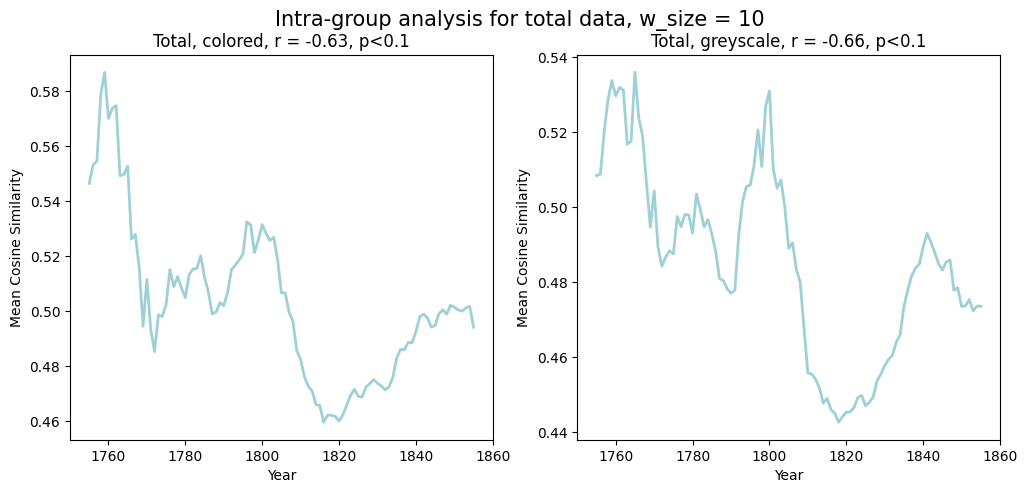

In [242]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# plot color
plot_diachronic_change(w_size = 10,
                        step_size= 1, 
                        df = color_subset, 
                        year_col = 'start_year',
                        canon_col = 'exb_canon', 
                        embedding_col = 'embedding', 
                        n_runs = 1, 
                        sampling = False, 
                        cutoff = 5,
                        cosim_to_plot='TOTAL_COSIM_MEAN',
                        ax = axs[0], 
                        color = '#75BCC6',
                        title = 'Total, colored', 
                        y_label= 'Mean Cosine Similarity')
    
# plot greyscale
plot_diachronic_change(w_size = 10,
                        step_size= 1, 
                        df = df, 
                        year_col = 'start_year',
                        canon_col = 'exb_canon', 
                        embedding_col = 'grey_embedding', 
                        n_runs = 1, 
                        sampling = False, 
                        cutoff = 5,
                        cosim_to_plot='TOTAL_COSIM_MEAN',
                        ax = axs[1], 
                        color = '#75BCC6',
                        title = 'Total, greyscale', 
                        y_label= 'Mean Cosine Similarity')

fig.suptitle('Intra-group analysis for total data, w_size = 10', size = 15, y=0.97)

9 is the smallest group size in a window
12 is the smallest group size in a window
3 is the smallest group size in a window
3 is the smallest group size in a window
5 is the smallest group size in a window
5 is the smallest group size in a window
9 is the smallest group size in a window
12 is the smallest group size in a window


Text(0.5, 0.97, 'Inter-group analysis for all canon variables, w_size = 10')

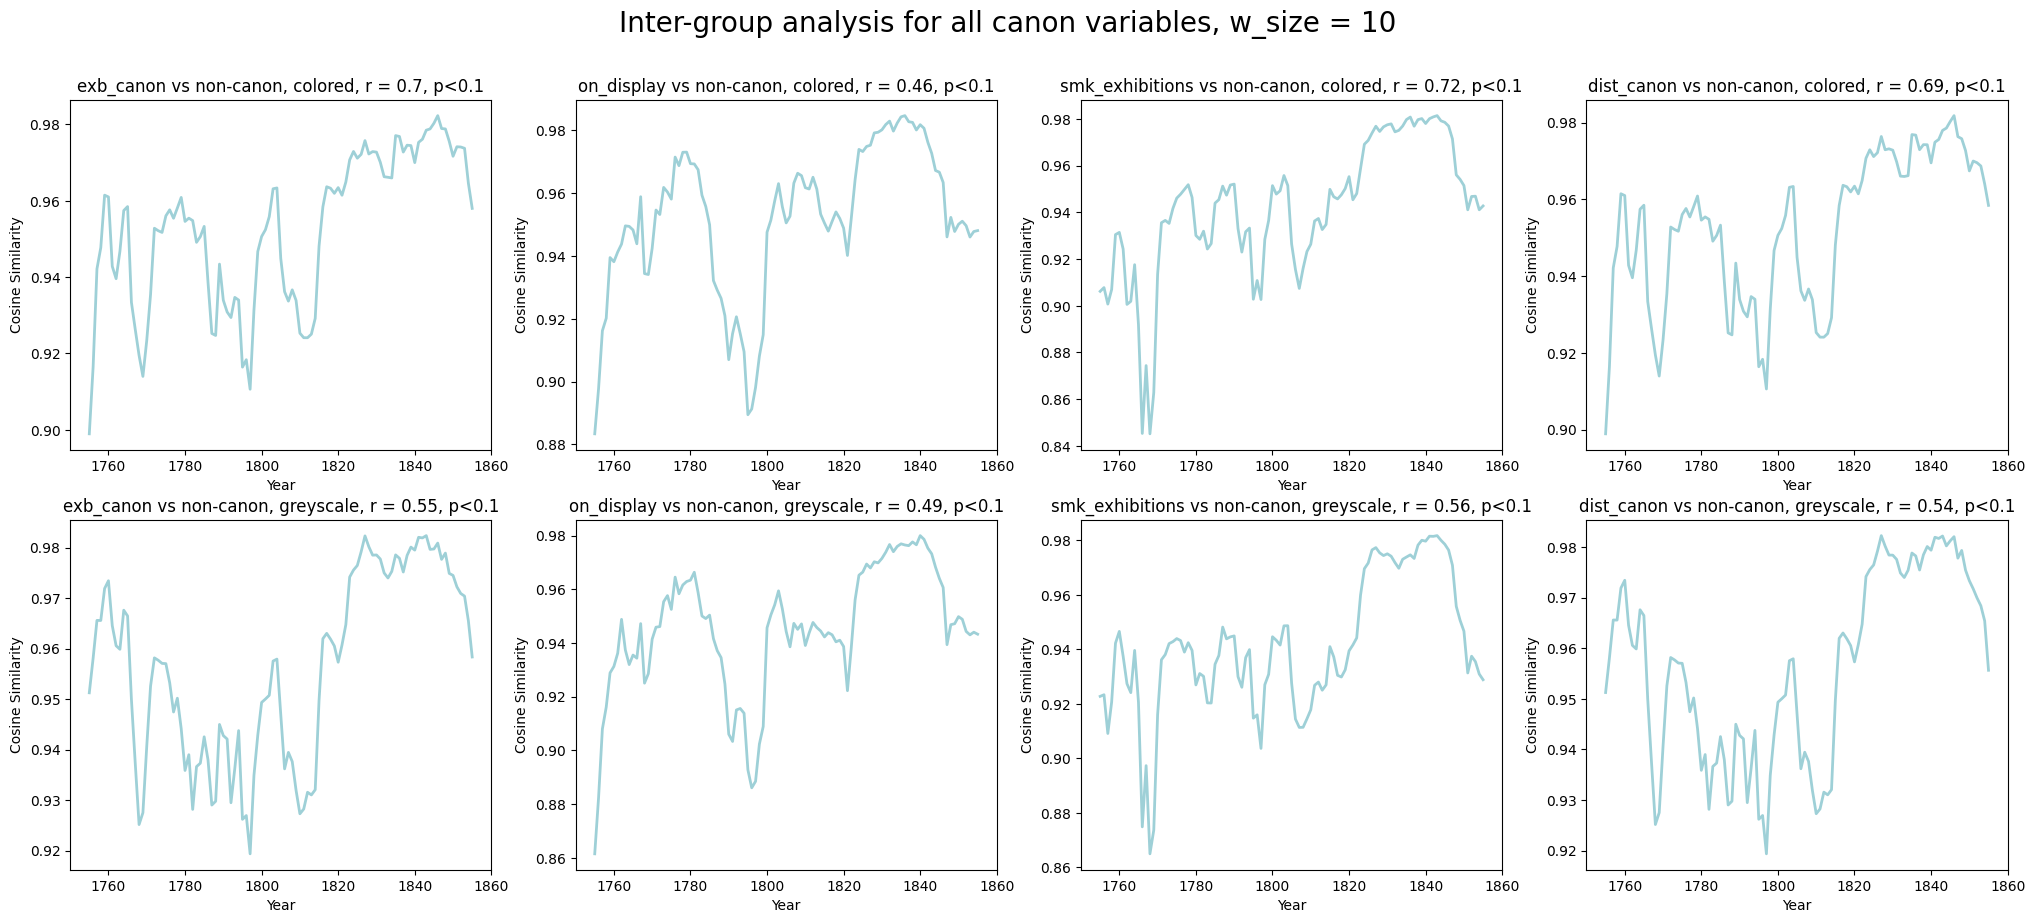

In [244]:
# create subplots
fig, axs = plt.subplots(2, 4, figsize=(25, 10))

for idx, col in enumerate(canon_cols):
    # plot color
    plot_diachronic_change(w_size = 10,
                           step_size= 1, 
                           df = color_subset, 
                           year_col = 'start_year',
                           canon_col = col, 
                           embedding_col = 'embedding', 
                           n_runs = 1, 
                           sampling = False, 
                           cutoff = 5,
                           cosim_to_plot='CANON_NONCANON_COSIM',
                           ax = axs[0,idx], 
                           color = '#75BCC6',
                           title = f'{col} vs non-canon, colored', 
                           y_label= 'Cosine Similarity')
    
    # plot greyscale
    plot_diachronic_change(w_size = 10,
                           step_size= 1, 
                           df = df, 
                           year_col = 'start_year',
                           canon_col = col, 
                           embedding_col = 'grey_embedding', 
                           n_runs = 1, 
                           sampling = False, 
                           cutoff = 5,
                           cosim_to_plot='CANON_NONCANON_COSIM',
                           ax = axs[1,idx], 
                           color = '#75BCC6',
                           title = f'{col} vs non-canon, greyscale', 
                           y_label= 'Cosine Similarity')

fig.suptitle('Inter-group analysis for all canon variables, w_size = 10', size = 20, y=0.97)

### Test diachronic change using mean production year variable

In [245]:
def add_mean_start_year(df):

    mean_years = []

    for idx, row in df.iterrows():
        if '-' in row['period']:
        #row['period'].str.contains('-'):
            start_year = int(row['period'].split('-')[0])
            end_year = int(row['period'].split('-')[-1])
        
            mean_year = (start_year + end_year) // 2
            mean_years.append(mean_year)

        else:
            mean_years.append(row['start_year'])


    df['mean_start_year'] = mean_years

    return df

In [246]:
df = add_mean_start_year(df)
color_subset = add_mean_start_year(color_subset)

In [247]:
df_removed = df.query('mean_start_year <= 1870')
color_subset_removed = color_subset.query('mean_start_year <= 1870')

39 is the smallest group size in a window
44 is the smallest group size in a window
23 is the smallest group size in a window
23 is the smallest group size in a window
21 is the smallest group size in a window
22 is the smallest group size in a window
39 is the smallest group size in a window
44 is the smallest group size in a window


Text(0.5, 0.97, 'Intra-group analysis for all canon variables using mean_start_year, w_size = 30')

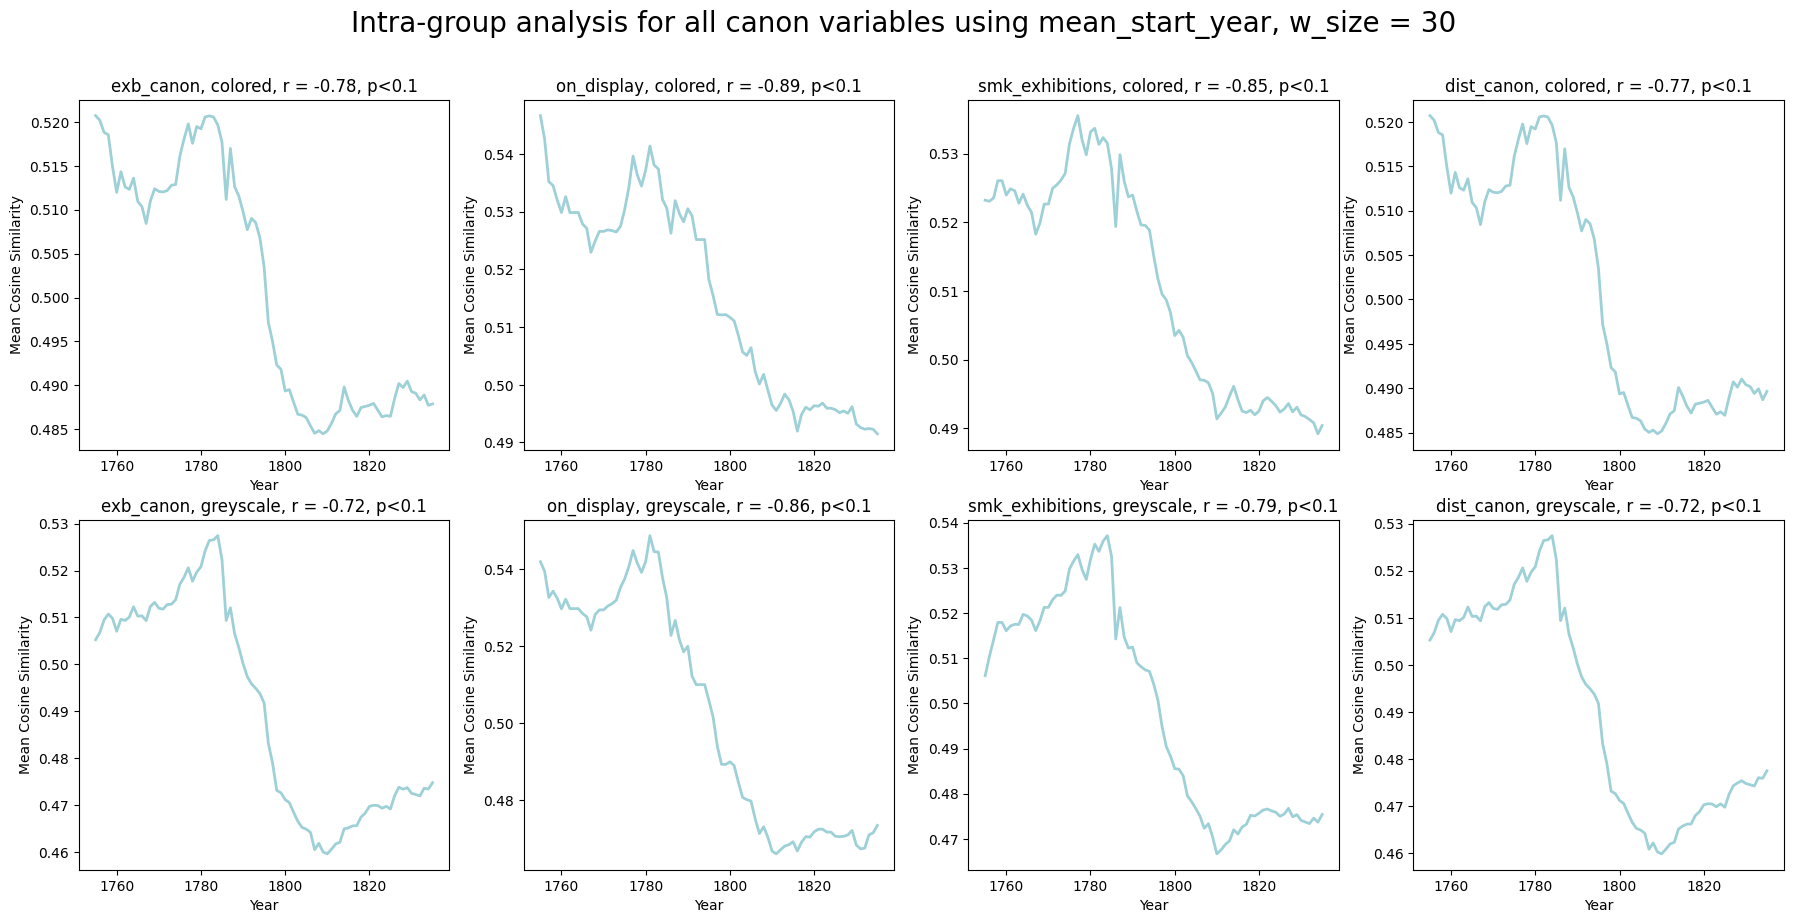

In [249]:
# create gathered intra-group plot for all canon categories using mean prod year instead of start prod year
fig, axs = plt.subplots(2, 4, figsize=(22, 10))

for idx, col in enumerate(canon_cols):
    # plot color
    plot_diachronic_change(w_size = 30,
                           step_size= 1, 
                           df = color_subset_removed, 
                           year_col = 'mean_start_year',
                           canon_col = col, 
                           embedding_col = 'embedding', 
                           n_runs = 1, 
                           sampling = False, 
                           cutoff = 5,
                           cosim_to_plot='CANON_COSIM_MEAN',
                           ax = axs[0,idx], 
                           color = '#75BCC6',
                           title = f'{col}, colored', 
                           y_label= 'Mean Cosine Similarity')
    
    # plot greyscale
    plot_diachronic_change(w_size = 30,
                           step_size= 1, 
                           df = df_removed, 
                           year_col = 'mean_start_year',
                           canon_col = col, 
                           embedding_col = 'grey_embedding', 
                           n_runs = 1, 
                           sampling = False, 
                           cutoff = 5,
                           cosim_to_plot='CANON_COSIM_MEAN',
                           ax = axs[1,idx], 
                           color = '#75BCC6',
                           title = f'{col}, greyscale', 
                           y_label= 'Mean Cosine Similarity')

fig.suptitle('Intra-group analysis for all canon variables using mean_start_year, w_size = 30', size = 20, y=0.97)

47 is the smallest group size in a window
52 is the smallest group size in a window
26 is the smallest group size in a window
26 is the smallest group size in a window
25 is the smallest group size in a window
27 is the smallest group size in a window
47 is the smallest group size in a window
52 is the smallest group size in a window


Text(0.5, 0.97, 'Inter-group analysis for all canon variables using mean_start_year, w_size = 30')

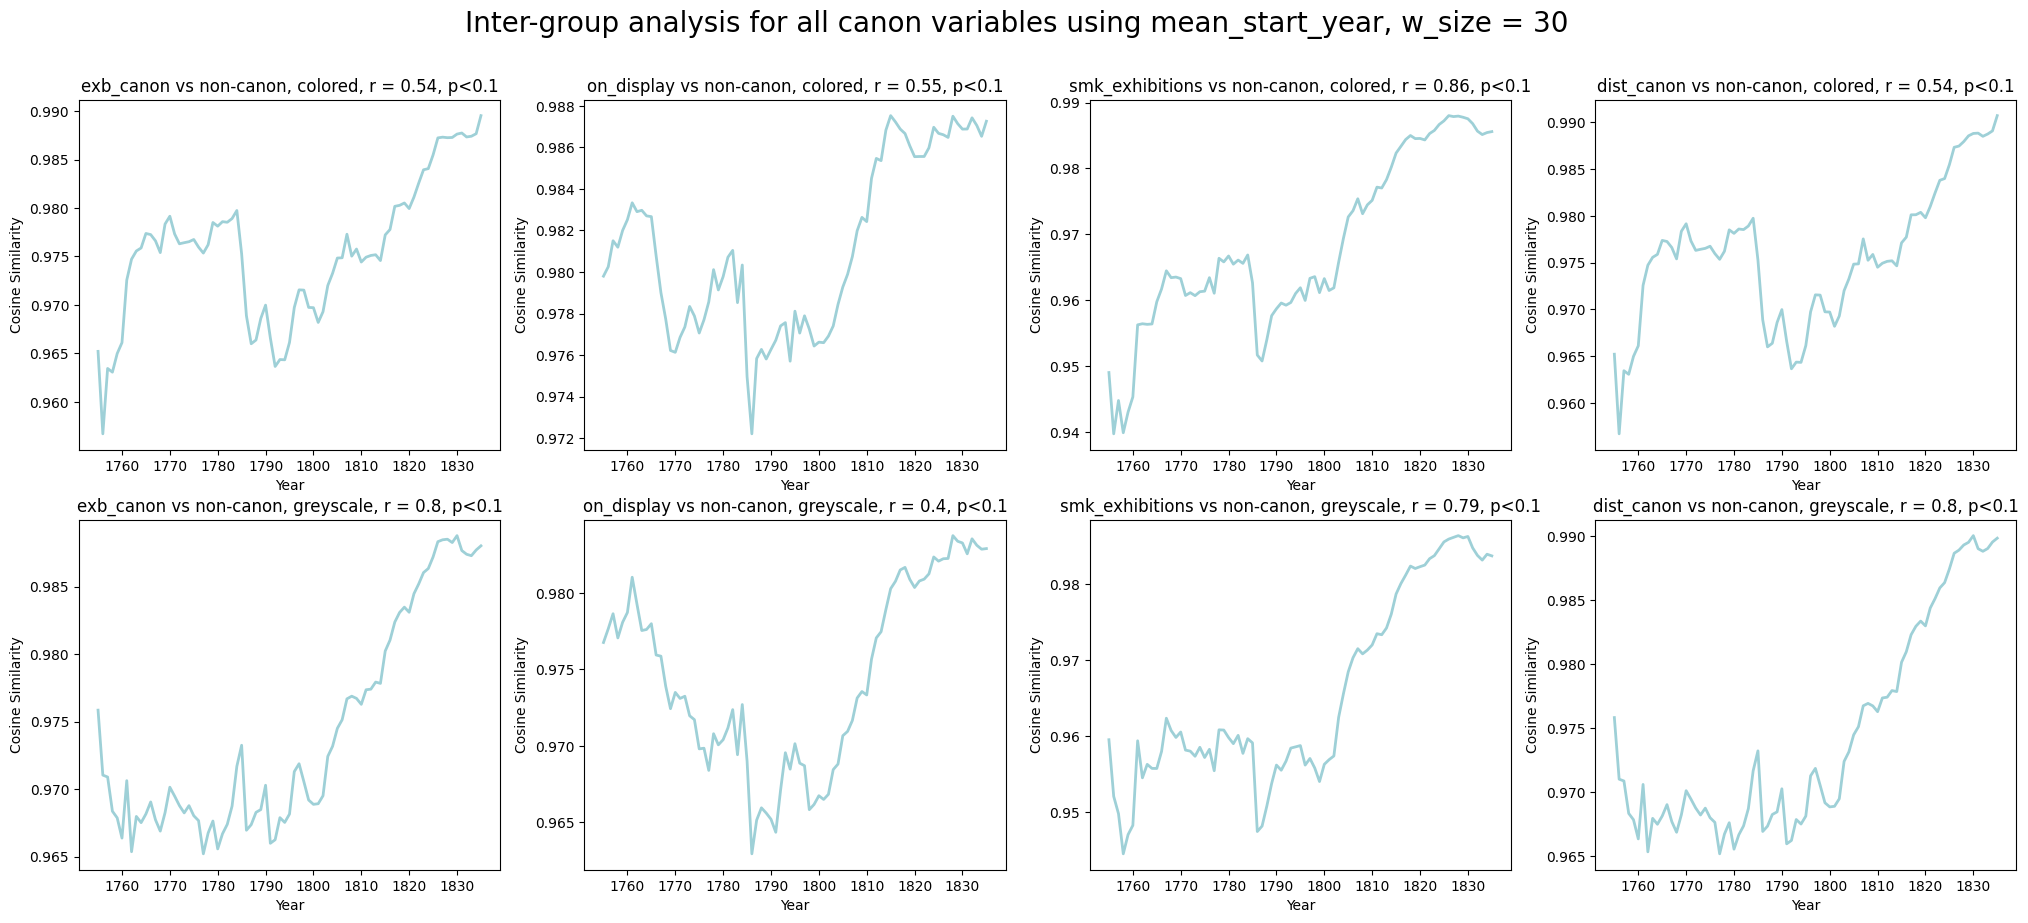

In [251]:
# create subplots
fig, axs = plt.subplots(2, 4, figsize=(25, 10))

for idx, col in enumerate(canon_cols):
    # plot color
    plot_diachronic_change(w_size = 30,
                           step_size= 1, 
                           df = color_subset, 
                           year_col = 'start_year',
                           canon_col = col, 
                           embedding_col = 'embedding', 
                           n_runs = 1, 
                           sampling = False, 
                           cutoff = 5,
                           cosim_to_plot='CANON_NONCANON_COSIM',
                           ax = axs[0,idx], 
                           color = '#75BCC6',
                           title = f'{col} vs non-canon, colored', 
                           y_label= 'Cosine Similarity')
    
    # plot greyscale
    plot_diachronic_change(w_size = 30,
                           step_size= 1, 
                           df = df, 
                           year_col = 'start_year',
                           canon_col = col, 
                           embedding_col = 'grey_embedding', 
                           n_runs = 1, 
                           sampling = False, 
                           cutoff = 5,
                           cosim_to_plot='CANON_NONCANON_COSIM',
                           ax = axs[1,idx], 
                           color = '#75BCC6',
                           title = f'{col} vs non-canon, greyscale', 
                           y_label= 'Cosine Similarity')

fig.suptitle('Inter-group analysis for all canon variables using mean_start_year, w_size = 30', size = 20, y=0.97)

### Test with entropy measures

In [252]:
def calc_signals(df, w_size, embedding_col, year_col):
    '''
    Calculate novelty, transience and resonance signals from image embeddings
    '''
    # convert embedding to array
    X = np.array(df[embedding_col])

    # convert array to probability distributions and back to array
    X_prob = [calc_vector_histogram(vect, bins=256) for vect in X]
    X_prob = np.array(X_prob)

    # calculate signal
    w_main = WindowedRollingDistance(
        measure='jensenshannon',
        window_size=w_size,
        estimate_error=True)

    signal = w_main.fit_transform(X_prob)

    # convert to dataframe
    signal_df = pd.DataFrame(signal)

    # add information about production year
    signal_df['year'] = df[year_col]

    return signal_df

In [260]:
def plot_canon_novelty(df, canon_col, embedding_col, w_size, year_col, col_or_grey, ax):
    
    # define canon df based on chosen canon variable
    if canon_col == 'total':
        df_canon = df
    else:
        # filter for canon
        df_canon = df[df[canon_col] == 'canon']

    # sort by start year, lowest to highest
    df_canon_sorted = df_canon.sort_values(by=year_col).reset_index(drop=True)

    # calculate novelty and resonance signals (windowed rolling distance function
    signal_df = calc_signals(df_canon_sorted, w_size, embedding_col, year_col)

    # exclude the first w_size rows as they are empty
    n_df = signal_df.iloc[w_size:, :]
    n_hat = n_df['N_hat'].tolist() # get novelty signal
    n_years = n_df['year'].tolist() # get year

    # plot raw novelty signal as well as smoothed signal with a gaussian filter
    ax.plot(n_years, n_hat, alpha=0.5)
    ax.plot(n_years, gaussian_filter1d(n_hat, 5), label='Novelty (Gaussian filter, sigma = 5)', color='blue')
    ax.set_ylabel(f'Average windowed Jensen-Shannon Distance (w={w_size})')
    ax.set_xlabel(year_col)
    ax.set_title(f'{canon_col}, {col_or_grey}, w_size = {w_size}')
    ax.legend(loc='upper right')


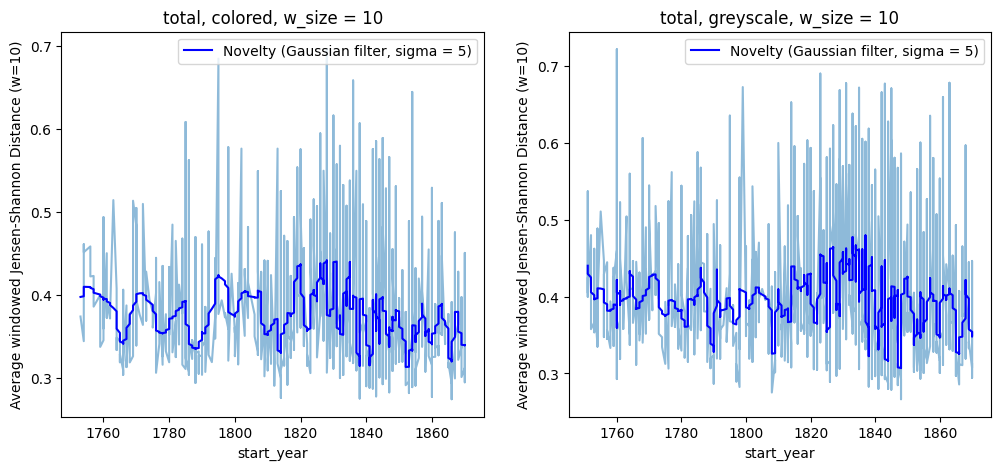

In [261]:
# total signal
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_canon_novelty(color_subset, 'total', 'embedding', 10, 'start_year', 'colored', axs[0])
plot_canon_novelty(df, 'total', 'grey_embedding', 10, 'start_year', 'greyscale', axs[1])

Text(0.5, 0.97, 'Novelty signal for all canon variables, w_size = 10, using start prod year')

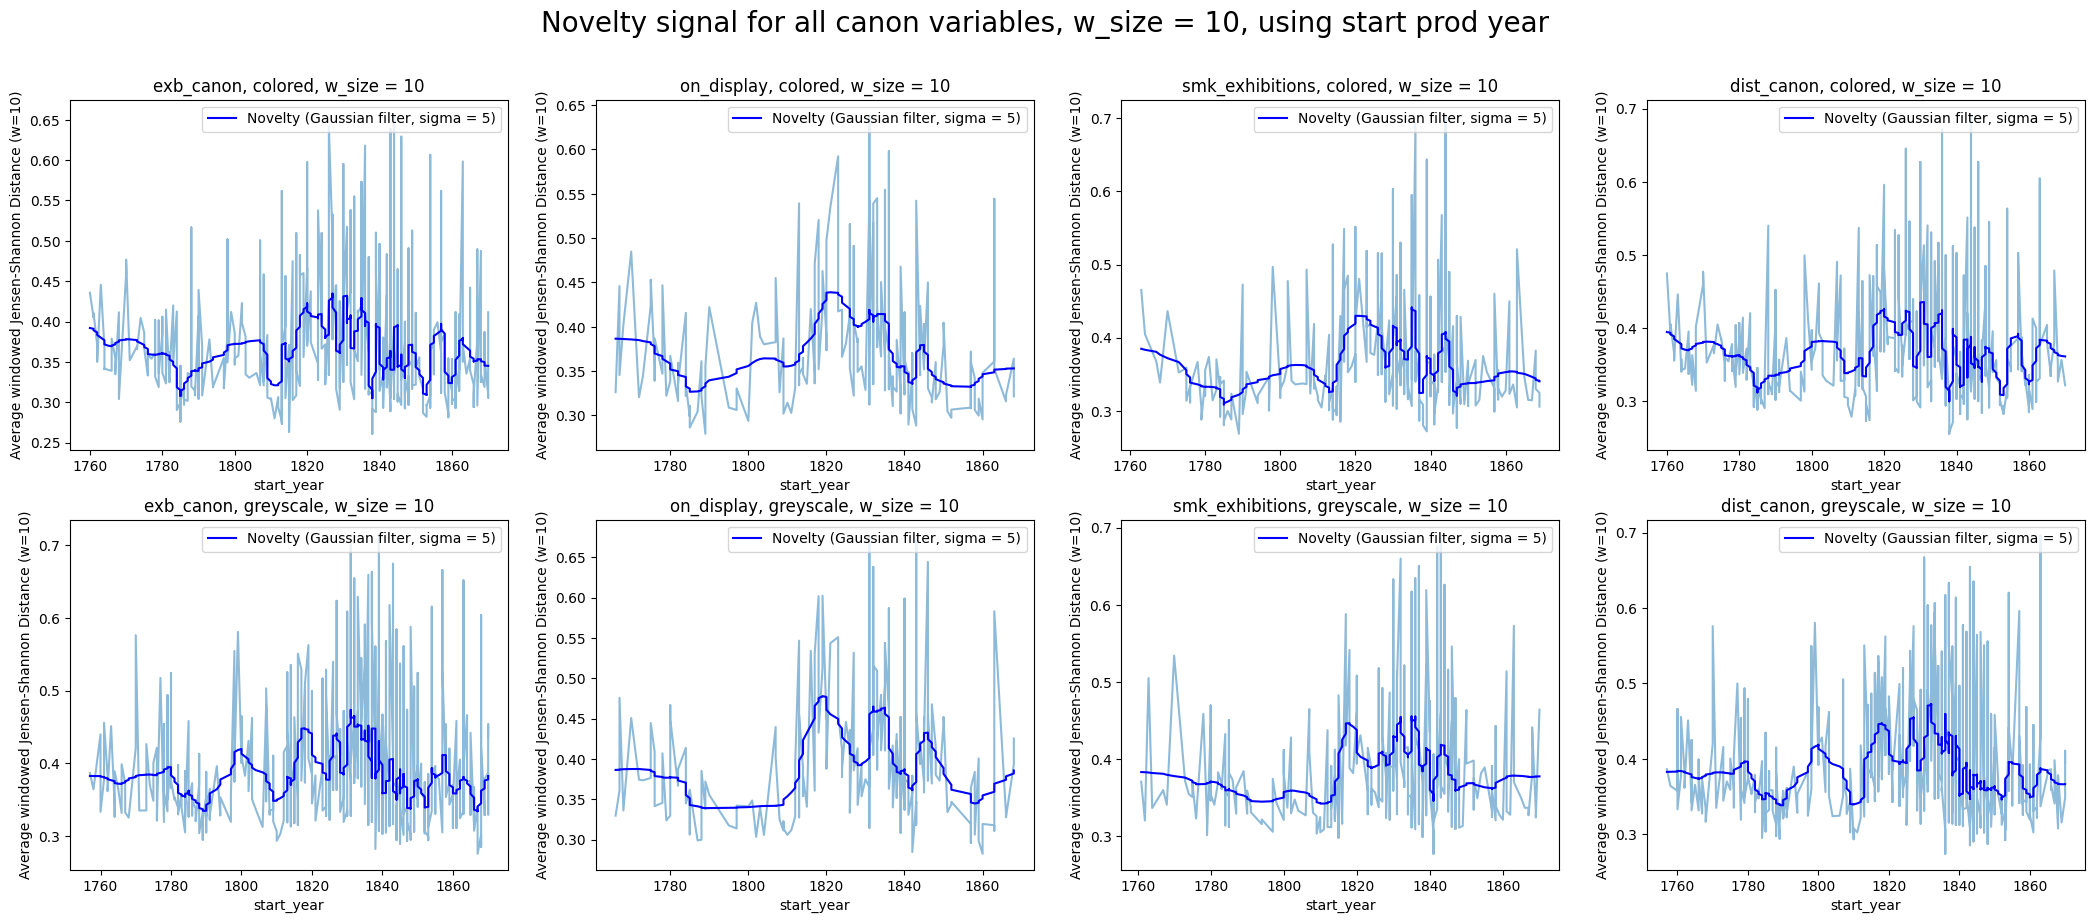

In [262]:
fig, axs = plt.subplots(2, 4, figsize=(26, 10))

for idx, col in enumerate(canon_cols):
    plot_canon_novelty(df = color_subset, 
                       canon_col = col, 
                       embedding_col = 'embedding', 
                       w_size = 10, 
                       year_col = 'start_year', 
                       col_or_grey = 'colored', 
                       ax = axs[0,idx])

    plot_canon_novelty(df = df,
                       canon_col = col,
                        embedding_col = 'grey_embedding', 
                        w_size = 10,
                        year_col = 'start_year', 
                        col_or_grey= 'greyscale', 
                        ax = axs[1,idx])

fig.suptitle('Novelty signal for all canon variables, w_size = 10, using start prod year', size = 20, y=0.97)

#### Entropy measures using mean production year

Text(0.5, 0.99, 'Novelty signal for all paintings, w_size = 10, using mean prod year')

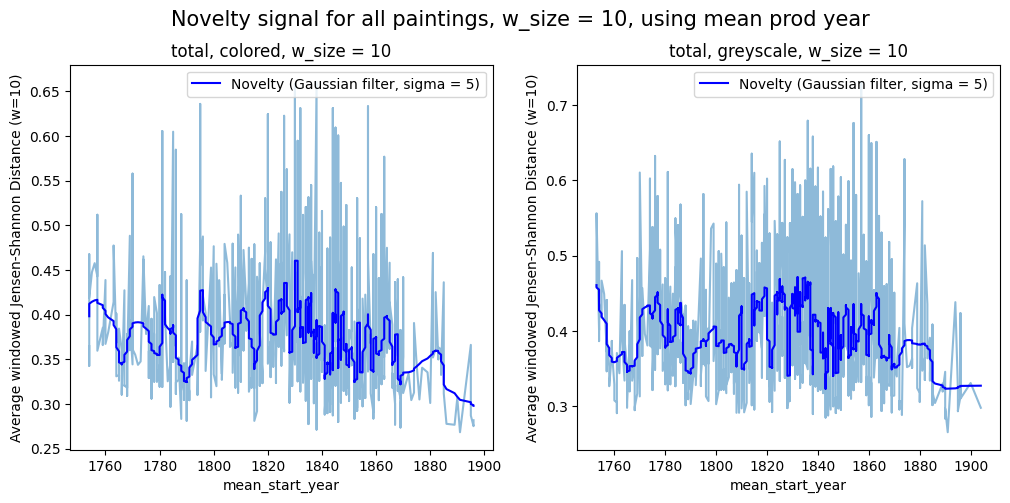

In [263]:
# total signal
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_canon_novelty(color_subset, 'total', 'embedding', 10, 'mean_start_year', 'colored', axs[0])
plot_canon_novelty(df, 'total', 'grey_embedding', 10, 'mean_start_year', 'greyscale', axs[1])

fig.suptitle('Novelty signal for all paintings, w_size = 10, using mean prod year', size = 15, y=0.99)

Text(0.5, 0.97, 'Novelty signal for all canon variables, w_size = 10, using mean prod year')

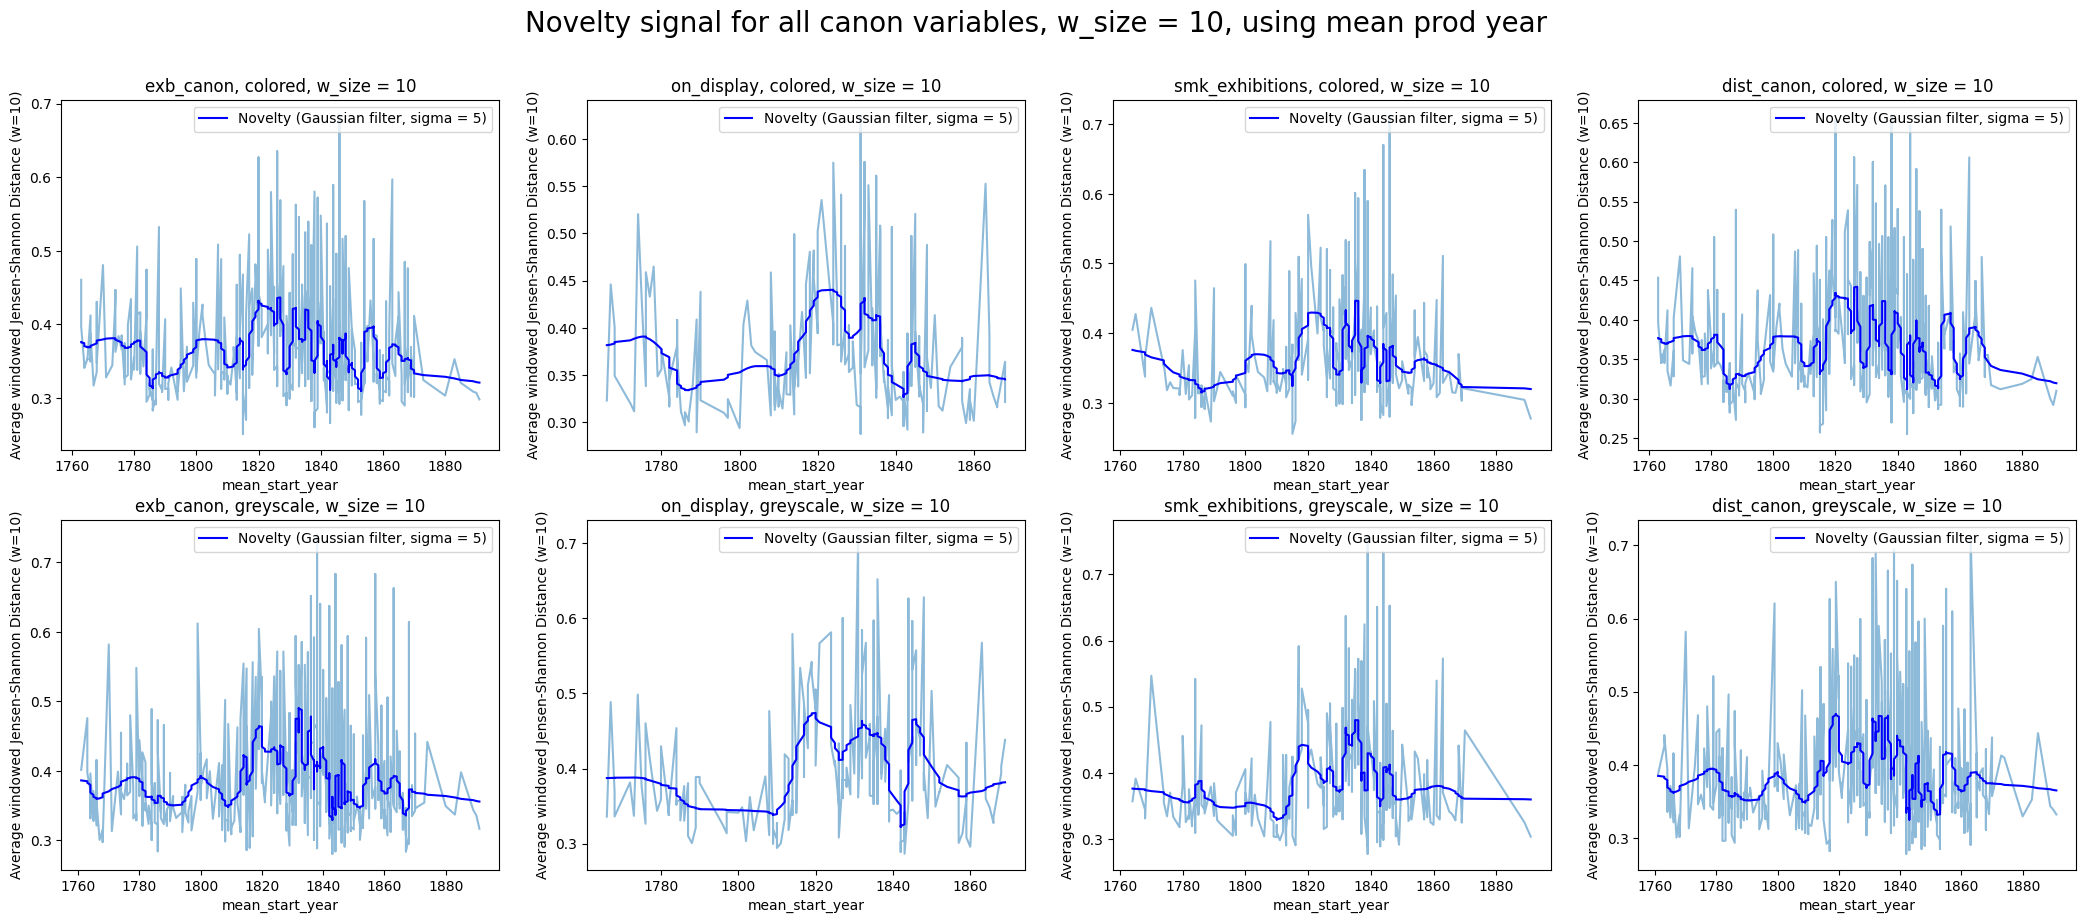

In [264]:
fig, axs = plt.subplots(2, 4, figsize=(26, 10))

for idx, col in enumerate(canon_cols):
    plot_canon_novelty(df = color_subset, 
                       canon_col = col, 
                       embedding_col = 'embedding', 
                       w_size = 10, 
                       year_col = 'mean_start_year', 
                       col_or_grey = 'colored', 
                       ax = axs[0, idx])

    plot_canon_novelty(df = df,
                       canon_col = col,
                        embedding_col = 'grey_embedding', 
                        w_size = 10,
                        year_col = 'mean_start_year', 
                        col_or_grey= 'greyscale', 
                        ax = axs[1, idx])

fig.suptitle('Novelty signal for all canon variables, w_size = 10, using mean prod year', size = 20, y=0.97)